<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Env" data-toc-modified-id="Env-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Env</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span></li></ul></li><li><span><a href="#Body" data-toc-modified-id="Body-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Body</a></span></li><li><span><a href="#Trial-Duration" data-toc-modified-id="Trial-Duration-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Trial Duration</a></span></li><li><span><a href="#Intertrial-Interval" data-toc-modified-id="Intertrial-Interval-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Intertrial Interval</a></span></li><li><span><a href="#Stationary-analysis" data-toc-modified-id="Stationary-analysis-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Stationary analysis</a></span></li><li><span><a href="#Hidden-Markov-Model" data-toc-modified-id="Hidden-Markov-Model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Hidden Markov Model</a></span></li><li><span><a href="#Final-images" data-toc-modified-id="Final-images-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Final images</a></span></li><li><span><a href="#Analysis-of-variance" data-toc-modified-id="Analysis-of-variance-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Analysis of variance</a></span></li></ul></div>

# Env

## Imports

In [2]:
# Data manipulation
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# spikelearn
import os
os.chdir('../../')
import sys
sys.path.append('.')

from spikelearn.data import io, SHORTCUTS
from spikelearn.data.selection import select
from spikelearn.visuals.visuals import raster_multiple, raster_plot

In [3]:
# Definitions
DRRD_RATS = ['DRRD 7','DRRD 8','DRRD 9','DRRD 10']
AUTOSHAPE_RATS = ['Autoshape 7','Autoshape 8','Autoshape 9','Autoshape 10']
ALL_RATS = DRRD_RATS + AUTOSHAPE_RATS

# Facilitators
BASE_FIG_SIZE = np.array([20, 4])
mpl.rc("figure", figsize=BASE_FIG_SIZE)
per_rat_plot = lambda nplots, rats: plt.subplots(nplots, len(rats), sharey=True, figsize=BASE_FIG_SIZE*[1, nplots])
# example: fig, axes = per_rat_plot(4)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from scipy.signal import detrend
from statsmodels.tsa.vector_ar import var_model
from statsmodels.tsa.filters.filtertools import recursive_filter
from statsmodels.tsa.statespace.varmax import VARMAX

## Functions

In [133]:
def singleRatBehaviorPlot(durations, tVec=None, threshold='max',cpax=True, s=20,
                            Tc = 1.5, kde='fl', kdeN = 100, ticksize=14,
                            axislabel_size=16, reverse=False, tmax = 5,
                            figsize = 4):
    #TODO document function
    """
    Plots the responses along the trials, together with the
    """
    f = plt.figure(figsize=(figsize,figsize))
    mpl.rcParams['font.size']=ticksize

    trialNumber = np.arange(len(durations))
    if tVec is None:
        tVec = (np.arange(len(durations)) == len(durations)//2).astype(int)

    # Behavioral dots
    nonRewarded = (durations < Tc)
    plt.scatter(durations[nonRewarded],trialNumber[nonRewarded],s=s,color='b')#=(0.6, 0.036000000000000004, 0.0))#(0.48, 0.1416, 0.12))



    rewarded = (durations >= Tc)
    plt.scatter(durations[rewarded],trialNumber[rewarded],color='g', s=s, marker='o')#(0.0, 0.6, 0.18600000000000008)

    plt.ylim([0,len(durations)]); plt.xlim([0,tmax]);
    plt.ylabel('Trial number',fontsize=axislabel_size);
    if not reverse:
        plt.xlabel('Time from nosepoke onset (s)',fontsize=axislabel_size)
    pcax = plt.gca()
    # Changepoint lines
    if threshold == 'max':
        plt.axhline(np.argmax(tVec), linestyle='-.', linewidth=6, color='k')
    else:
        pass
        plt.hlines(np.nonzero(tVec>threshold)[0],0,max(durations),'k',linestyle='-.',linewidth=6)

    # Changepoint lateral
    if cpax:
        cpax = f.add_axes([1,.045,1,.945])
        cpax.plot(tVec,trialNumber,'k'); plt.yticks([]);
        plt.ylim([0,len(durations)]); plt.xlabel('Odds',fontsize=axislabel_size)
        pos1 = pcax.get_position() # get the original position
        pos2 = [pos1.x0  + .85, pos1.y0,  pos1.width, pos1.height]
        cpax.set_position(pos2) # set a new position
    # Kernel density
    if kde is not False:
        kdax = f.add_axes([.06,1,.925,1])
        pos1 = pcax.get_position() # get the original position
        if reverse:
            pos2 = [pos1.x0 , pos1.y0 - .85,  pos1.width, pos1.height]
            plt.xlabel('Time from nosepoke onset (s)',fontsize=axislabel_size)
        else:
            pos2 = [pos1.x0 , pos1.y0 + .85,  pos1.width, pos1.height]
        plt.ylabel('Probability density', fontsize=axislabel_size)
        kdax.set_position(pos2) # set a new position
    if kde in  ['fl','firstlast']:
        first = durations[:kdeN]
        last = durations[-kdeN:]

        sns.kdeplot(first,label='First %d trials'%kdeN,color='b',linewidth=4);
        sns.kdeplot(last, label = 'Last %d trials'%kdeN,color = 'g',linewidth=4);
        plt.xlim([0,tmax]);plt.ylim([0,0.8])

        pcax.axhline(kdeN,linestyle='--',color='b',linewidth=4);
        pcax.arrow(1,kdeN,0,-30, head_width=0.05, head_length=10, fc='b', ec='b',linewidth=2)
        pcax.arrow(4,kdeN,0,-30, head_width=0.05, head_length=10, fc='b', ec='b',linewidth=2)

        pcax.axhline(len(durations)-kdeN,linestyle='--',color = 'magenta',linewidth=4)
        pcax.arrow(1,len(durations)-kdeN,0,30, head_width=0.05, head_length=10, fc='magenta', ec='magenta',linewidth=2)
        pcax.arrow(4,len(durations)-kdeN,0,30, head_width=0.05, head_length=10, fc='magenta', ec='magenta',linewidth=2)

    elif kde in ['cp','fromcp']:
        first = durations[np.argmax(tVec)-kdeN:np.argmax(tVec)]
        last = durations[np.argmax(tVec):np.argmax(tVec)+kdeN]

        sns.kdeplot(first,label='First %d trials'%kdeN,color='b',linewidth=2);
        sns.kdeplot(last, label = 'Last %d trials'%kdeN,color = 'magenta',linewidth=4);
        plt.xlim([0,tmax]);plt.ylim([0,0.8])

        pcax.axhline(np.argmax(tVec)-kdeN,linestyle='--',color='b',linewidth=4);
        pcax.arrow(1,np.argmax(tVec)-kdeN,0,30, head_width=0.05, head_length=10, fc='b', ec='b',linewidth=2)
        pcax.arrow(4,np.argmax(tVec)-kdeN,0,30, head_width=0.05, head_length=10, fc='b', ec='b',linewidth=2)

        pcax.axhline(np.argmax(tVec)+kdeN,linestyle='--',color = 'magenta',linewidth=4)
        pcax.arrow(1,np.argmax(tVec)+kdeN,0,-30, head_width=0.05, head_length=10, fc='magenta', ec='magenta',linewidth=2)
        pcax.arrow(4,np.argmax(tVec)+kdeN,0,-30, head_width=0.05, head_length=10, fc='magenta', ec='magenta',linewidth=2)

In [133]:
def simple_behavior(durations, Tc = 1.5, NRcolors=['r', 'b'], 
                    s=10, reverse=False, tmax = 5, figsize = 4):
    
    #TODO document function
    """
    Plots the responses along the trials, together with the
    """
    
    trialNumber = np.arange(len(durations))

    # Behavioral dots
    nonRewarded = (durations < Tc)
    plt.scatter(durations[nonRewarded],trialNumber[nonRewarded],s=s,color=NRcolors[0])
    rewarded = (durations >= Tc)
    plt.scatter(durations[rewarded],trialNumber[rewarded],color=NRcolors[1], s=s)
    plt.ylim([0,len(durations)]); plt.xlim([0,tmax]);
    plt.ylabel('Trial number',fontsize=axislabel_size);
    if not reverse:
        plt.xlabel('Time from nosepoke onset (s)',fontsize=axislabel_size)
    pcax = plt.gca()
    # Changepoint lines
    if threshold == 'max':
        plt.axhline(np.argmax(tVec), linestyle='-.', linewidth=6, color='k')
    else:
        pass
        plt.hlines(np.nonzero(tVec>threshold)[0],0,max(durations),'k',linestyle='-.',linewidth=6)

    # Changepoint lateral
    if cpax:
        cpax = f.add_axes([1,.045,1,.945])
        cpax.plot(tVec,trialNumber,'k'); plt.yticks([]);
        plt.ylim([0,len(durations)]); plt.xlabel('Odds',fontsize=axislabel_size)
        pos1 = pcax.get_position() # get the original position
        pos2 = [pos1.x0  + .85, pos1.y0,  pos1.width, pos1.height]
        cpax.set_position(pos2) # set a new position
    # Kernel density
    if kde is not False:
        kdax = f.add_axes([.06,1,.925,1])
        pos1 = pcax.get_position() # get the original position
        if reverse:
            pos2 = [pos1.x0 , pos1.y0 - .85,  pos1.width, pos1.height]
            plt.xlabel('Time from nosepoke onset (s)',fontsize=axislabel_size)
        else:
            pos2 = [pos1.x0 , pos1.y0 + .85,  pos1.width, pos1.height]
        plt.ylabel('Probability density', fontsize=axislabel_size)
        kdax.set_position(pos2) # set a new position
    if kde in  ['fl','firstlast']:
        first = durations[:kdeN]
        last = durations[-kdeN:]

        sns.kdeplot(first,label='First %d trials'%kdeN,color='b',linewidth=4);
        sns.kdeplot(last, label = 'Last %d trials'%kdeN,color = 'g',linewidth=4);
        plt.xlim([0,tmax]);plt.ylim([0,0.8])

        pcax.axhline(kdeN,linestyle='--',color='b',linewidth=4);
        pcax.arrow(1,kdeN,0,-30, head_width=0.05, head_length=10, fc='b', ec='b',linewidth=2)
        pcax.arrow(4,kdeN,0,-30, head_width=0.05, head_length=10, fc='b', ec='b',linewidth=2)

        pcax.axhline(len(durations)-kdeN,linestyle='--',color = 'magenta',linewidth=4)
        pcax.arrow(1,len(durations)-kdeN,0,30, head_width=0.05, head_length=10, fc='magenta', ec='magenta',linewidth=2)
        pcax.arrow(4,len(durations)-kdeN,0,30, head_width=0.05, head_length=10, fc='magenta', ec='magenta',linewidth=2)

    elif kde in ['cp','fromcp']:
        first = durations[np.argmax(tVec)-kdeN:np.argmax(tVec)]
        last = durations[np.argmax(tVec):np.argmax(tVec)+kdeN]

        sns.kdeplot(first,label='First %d trials'%kdeN,color='b',linewidth=2);
        sns.kdeplot(last, label = 'Last %d trials'%kdeN,color = 'magenta',linewidth=4);
        plt.xlim([0,tmax]);plt.ylim([0,0.8])

        pcax.axhline(np.argmax(tVec)-kdeN,linestyle='--',color='b',linewidth=4);
        pcax.arrow(1,np.argmax(tVec)-kdeN,0,30, head_width=0.05, head_length=10, fc='b', ec='b',linewidth=2)
        pcax.arrow(4,np.argmax(tVec)-kdeN,0,30, head_width=0.05, head_length=10, fc='b', ec='b',linewidth=2)

        pcax.axhline(np.argmax(tVec)+kdeN,linestyle='--',color = 'magenta',linewidth=4)
        pcax.arrow(1,np.argmax(tVec)+kdeN,0,-30, head_width=0.05, head_length=10, fc='magenta', ec='magenta',linewidth=2)
        pcax.arrow(4,np.argmax(tVec)+kdeN,0,-30, head_width=0.05, head_length=10, fc='magenta', ec='magenta',linewidth=2)

# Body

In [44]:
from spikelearn.visuals.visuals import singleRatBehaviorPlot, 

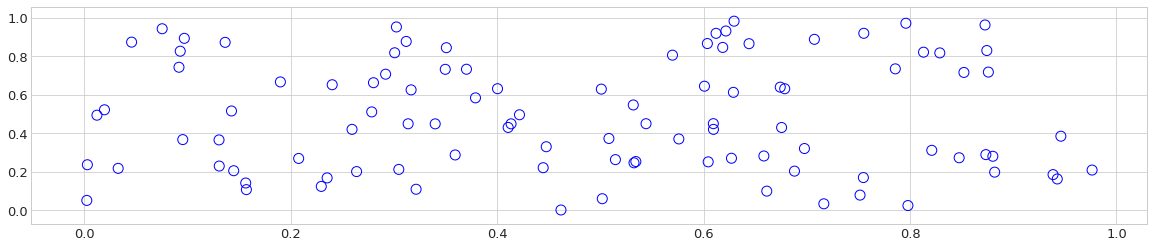

In [217]:
plt.scatter(np.random.rand(100),np.random.rand(100), marker='o',s=100, facecolors='none',edgecolor='b')

In [57]:
import matplotlib as mlp

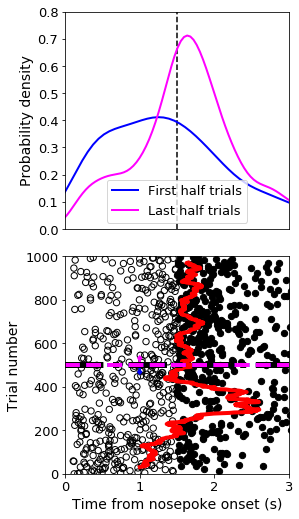

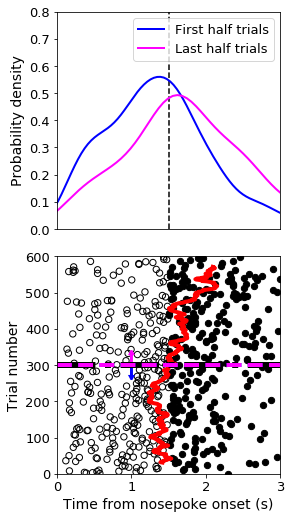

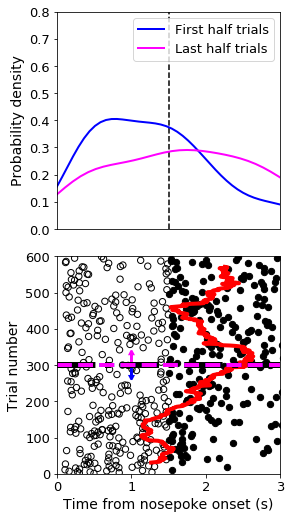

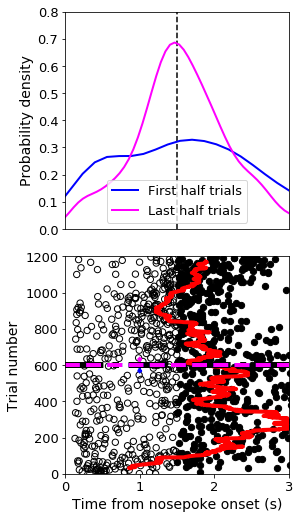

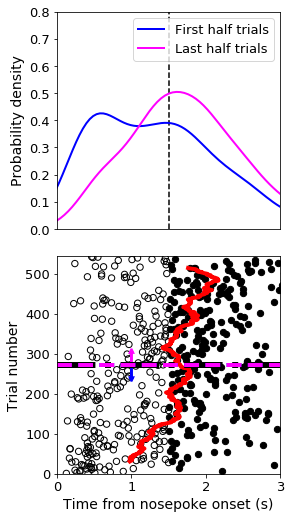

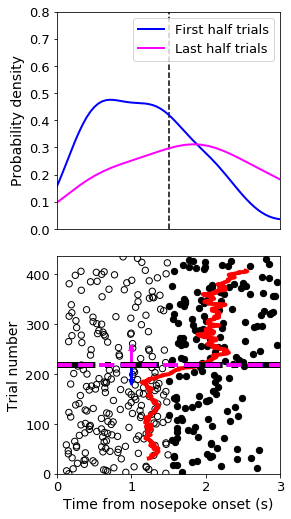

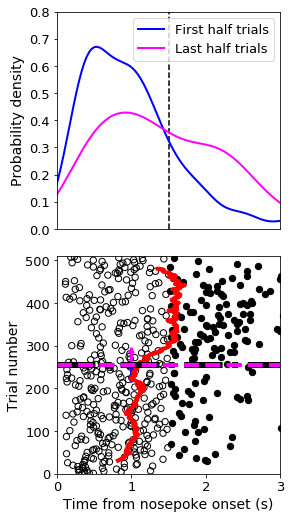

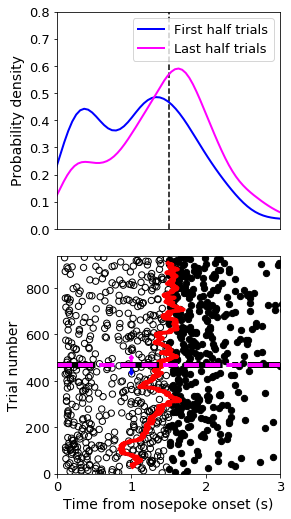

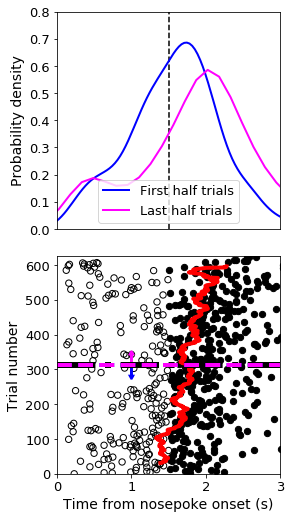

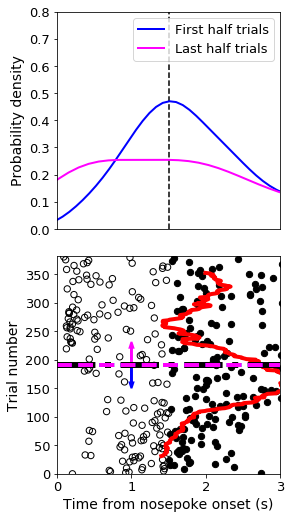

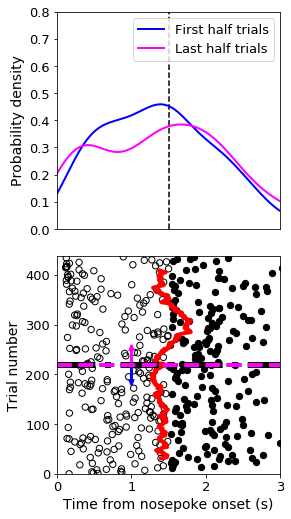

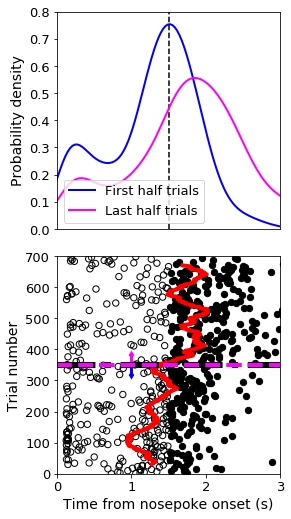

In [85]:
for label in SHORTCUTS['groups']['eletro']:
    fig, ax = plt.subplots(figsize=(4,4))
    dur = select(io.load(label, 'behav_stats'), is_tired=False).duration
    singleRatBehaviorPlot(dur, kde='fl',ticksize=13, axislabel_size=14, s=40,
                          cpax=False, reverse=False, tmax=3, kdeN='half')
    plt.savefig('reports/figures/behavior/{}_durations.png'.format(label), bbox_inches='tight')

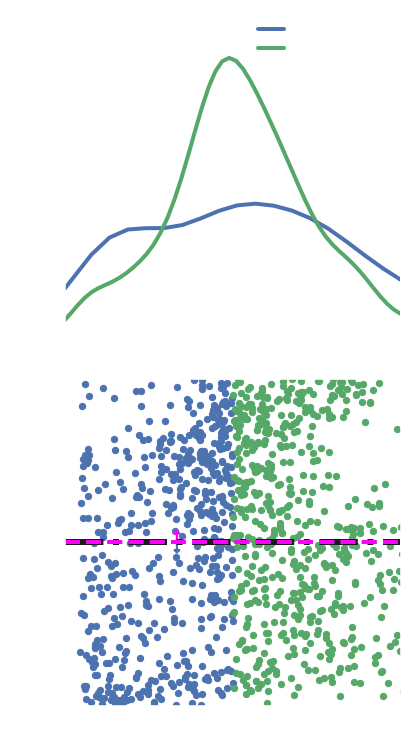

In [134]:
dur = select(io.load('DRRD 10', 'behav_stats'), is_tired=False).duration

singleRatBehaviorPlot(dur, kde='fl',ticksize=13, axislabel_size=14, s=40,
                      cpax=False, reverse=False, tmax=3, kdeN=600, figsize=6)

# plt.savefig('reports/figures/rat10_white_behav.png', dpi=150, transparent=True, bbox_inches ='tight')

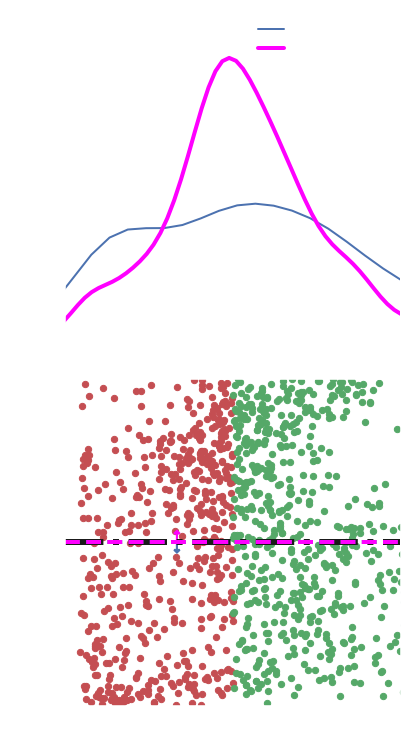

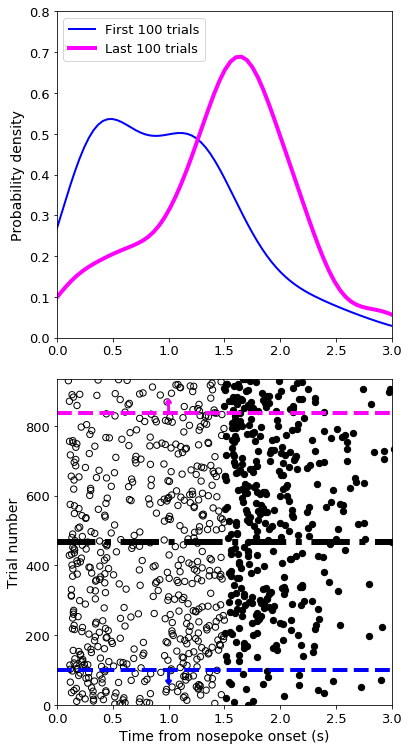

In [33]:
dur = io.load('ELI 6', 'behavior').duration
singleRatBehaviorPlot(dur, kde='fl',ticksize=13, axislabel_size=14, s=40,
                      cpax=False, reverse=False, tmax=3, kdeN=100, figsize=6)

In [ ]:
dur = io.load('DRRD 7', 'behavior').duration
singleRatBehaviorPlot(dur, kde='fl',ticksize=13, axislabel_size=14, s=40,
                      cpax=False, reverse=False, tmax=3, kdeN=596, figsize=6)

# Trial Duration

In [86]:
beh = pd.DataFrame()
for label in SHORTCUTS['groups']['eletro']:
    behav = io.load(label, 'behav_stats')
    beh = beh.append(pd.DataFrame({'correct':(behav.duration>1.5).sum(),
                                   'total':behav.shape[0]}, index=[label]))
    
    


In [106]:
((beh.correct/beh.total)*100).astype(int)


DRRD 7     54
DRRD 8     56
DRRD 9     54
DRRD 10    61
ELI 3      51
ELI 4      50
ELI 5      30
ELI 6      43
ELI 3_2    65
ELI 4_2    58
ELI 5_2    46
ELI 6_2    54
dtype: int64

# Intertrial Interval

In [19]:
beh = pd.DataFrame()
neu = {}
for label in SHORTCUTS['groups']['eletro']:
    behav = io.load(label, 'behav_stats')
    beh = beh.append(pd.DataFrame({'correct':(behav.duration>1.5).sum(),
                                   'total':behav.shape[0]}, index=[label]))
    neu[label] = io.load(label, 'huge_smoothed').loc[1]
    


In [ ]:
neu['rat'] = neu

In [37]:
neu['ELI 3']

area
PFC     4
STR    10
Name: quality, dtype: int64

In [ ]:
for label in SHORTCUTS['groups']['EZ']:
    print(label, ':', (neu[label].groupby('area').quality.apply(lambda x: (x>0).sum())))

In [41]:
for label in SHORTCUTS['groups']['DRRD']:
    print(label, neu[label].is_selected.sum())

DRRD 7 23
DRRD 8 28
DRRD 9 14
DRRD 10 68


In [21]:
neu['DRRD 8'].is_selected.sum()

28

In [17]:
neu['DRRD 7'].loc[1]

full  \
unit                                                      
0                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
1     [27.908886707688374, 28.068031071910042, 28.22...   
2     [27.345394437093972, 25.82698859066931, 23.163...   
3                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
4     [47.394067658540116, 46.808180585110456, 45.68...   
5     [118.16419100583146, 118.32261385178062, 118.3...   
6     [123.57580214348717, 121.80259789784314, 118.5...   
7                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
8                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
9                        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
10    [4.118848813611691, 3.930038710383074, 3.57405...   
11    [198.69113778808912, 198.08059067086873, 197.0...   
12    [7.540978558250348, 7.692807907276029, 8.01001...   
13    [231.35966683644767, 231.07535521536306, 230.3...   
14    [2.2109807553610707, 2.0728024479522524, 1.821...   
15                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
16                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
17    [422.7065475650938, 425.64170356342623, 431.10...   
18    [112.47557113711785, 111.08181703748805, 108.4...   
19    [6.295403794484589, 5.967296925751267, 5.36889...   
20    [72.60630049584098, 72.39090044023801, 71.8703...   
21                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
22                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
23    [7.858651638892351, 7.985303531050848, 8.17978...   
24    [54.486468228619415, 54.159568644742905, 53.59...   
25    [0.7982587930630527, 1.0194665589621952, 1.408...   
26    [280.45107717123005, 279.0910856838809, 276.45...   
27    [11.012712413702754, 10.774191609307913, 10.29...   
28                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
29    [6.613953942299723, 6.175091660165265, 5.43259...   
...                                                 ...   
64                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
65                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
66                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
67    [0.7921612355337486, 1.014609578482162, 1.4065...   
68    [2.3428625047858733, 2.158768095413629, 1.8470...   
69                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
70    [301.08382835978205, 305.4418681086722, 313.23...   
71    [149.90332610286023, 151.57836459236145, 154.5...   
72    [6.87665973335589, 6.368608694789971, 5.484437...   
73                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
74                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
75    [52.00786190164708, 51.933818792868685, 51.765...   
76    [5.768613458624239, 5.5199381129309835, 5.1467...   
77    [4.377763003353174, 4.101738444263111, 3.61717...   
78                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
79    [90.35419258571677, 89.4520219437316, 87.71939...   
80                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
81                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
82    [87.97652308812108, 88.17542769330394, 88.2995...   
83                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
84                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
85                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
86    [12.791368284041184, 12.528255313301905, 12.02...   
87                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
88    [13.65407627630353, 13.12051577834053, 12.2077...   
89                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
90                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
91                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
92                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   
93                       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]   

                                         full_times cropped cropped_times  \
unit                                                                        
0     [-500.0, -400.0, -300.0, -200.0, -100.0, 0.0]      []            []   
1     [-500.0, -400.0, -300.0, -200.0, -100.0, 0.0]      []            []   
2     [-500.0, -400.0, -3

In [ ]:
l

In [5]:
beh

correct  total
DRRD 7       654   1192
DRRD 8       454    801
DRRD 9       504    932
DRRD 10     1030   1671
ELI 3        278    543
ELI 4        218    436
ELI 5        156    509
ELI 6        404    936
ELI 3_2      410    625
ELI 4_2      222    381
ELI 5_2      203    437
ELI 6_2      382    699

In [527]:
bhv = {}
for label in SHORTCUTS['groups']['day1']:
    bhv[label] = select(io.load(label, 'behav_stats'))
    bhv[label]['rat'] = int(label.split()[-1][0]) if '_2' in label else int(label.split()[-1])

In [114]:
%run ../../ConvTech/ConvTech/black.ipynb

In [38]:
bhv['DRRD 10'].intertrial_interval[bhv['DRRD 10'].intertrial_interval>150]

trial
1377     173.315932
1538     202.261054
1542     437.641994
1653     189.428654
1663     210.758369
1666     447.795528
1668     598.764216
1671    1125.208105
Name: intertrial_interval, dtype: float64

In [490]:
def meanmax(S, N=3):
    return np.mean(sorted(S)[-N:])

Text(-220,28,'ITI (minutes)')

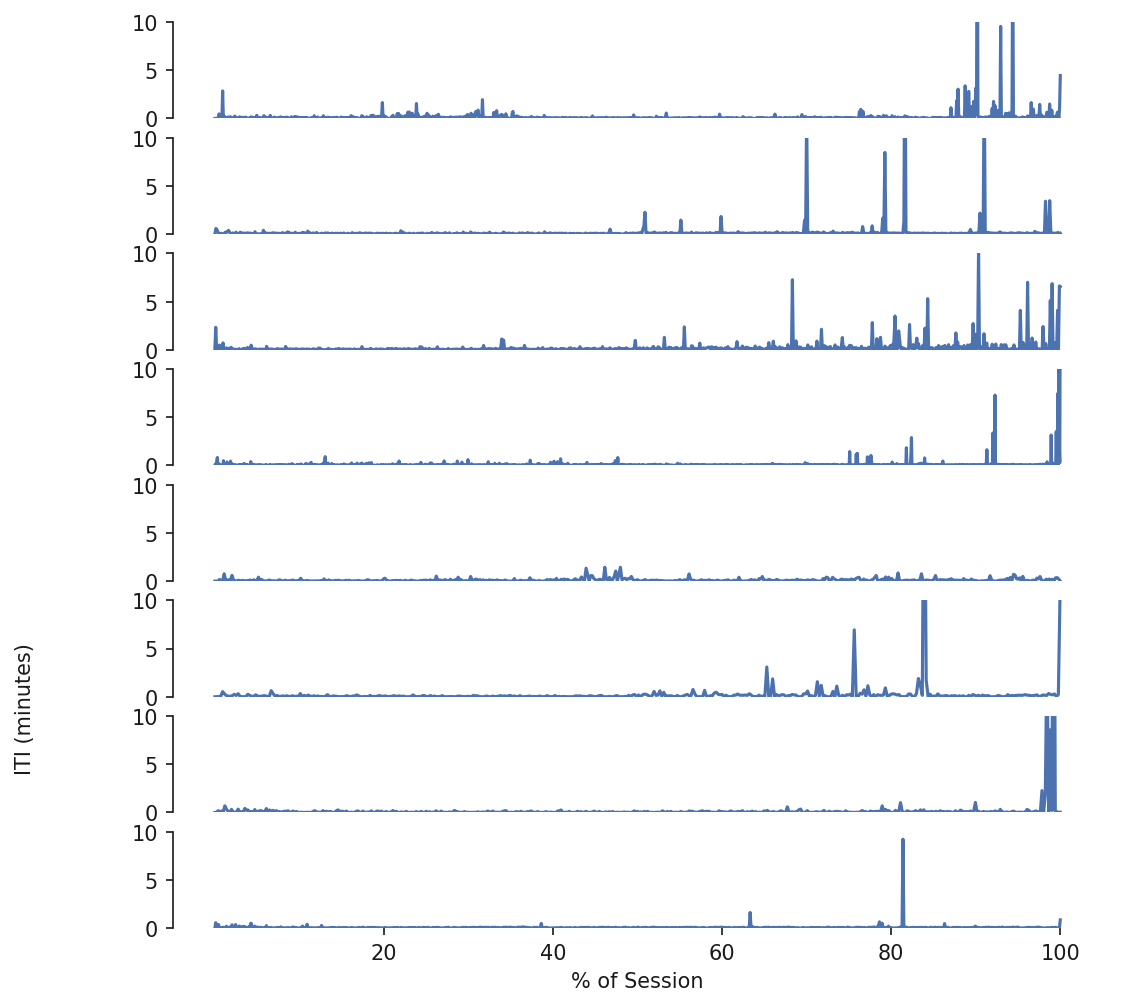

In [484]:
cps = [1030, 555, 630, 1250]
fig, ax = plt.subplots(8, 1, figsize=(8,8), dpi=150, sharey=True)
for i, rat in enumerate(SHORTCUTS['groups']['day1']):
    iti = bhv[rat]['intertrial_interval']
    (iti/60).plot(ax=ax[i]);
#     (iti/60).rolling(40).apply(meanmax).plot(ax=ax[i])
#     ax[i].set_ylim(0,10)
#     ax[i].vlines(cps[i], 0, 600, color='r', linestyle='--', linewidth=2)
    sns.despine(bottom=True)
    if i<7:
        plt.sca(ax[i])
        plt.xticks([])
        plt.xlabel('')
    else:
        plt.sca(ax[i])
        idxs = list(zip(*[(pd.Series(iti.index).quantile(i), int(i*100)) for i in [.2,.4,.6,.8,1]]))
        plt.xticks(idxs[0], idxs[1])
        plt.xlabel('% of Session')
        plt.grid(False, axis='x')
        
plt.ylim(0,10)

plt.text(-220, 28, 'ITI (minutes)', rotation=90)
# plt.savefig('reports/figures/iti_black.png', dpi=150, transparent=True, bbox='tight')

/disk1/home/svo6059/anaconda3/envs/chatbot_v2/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


Text(-220,28,'ITI (minutes)')

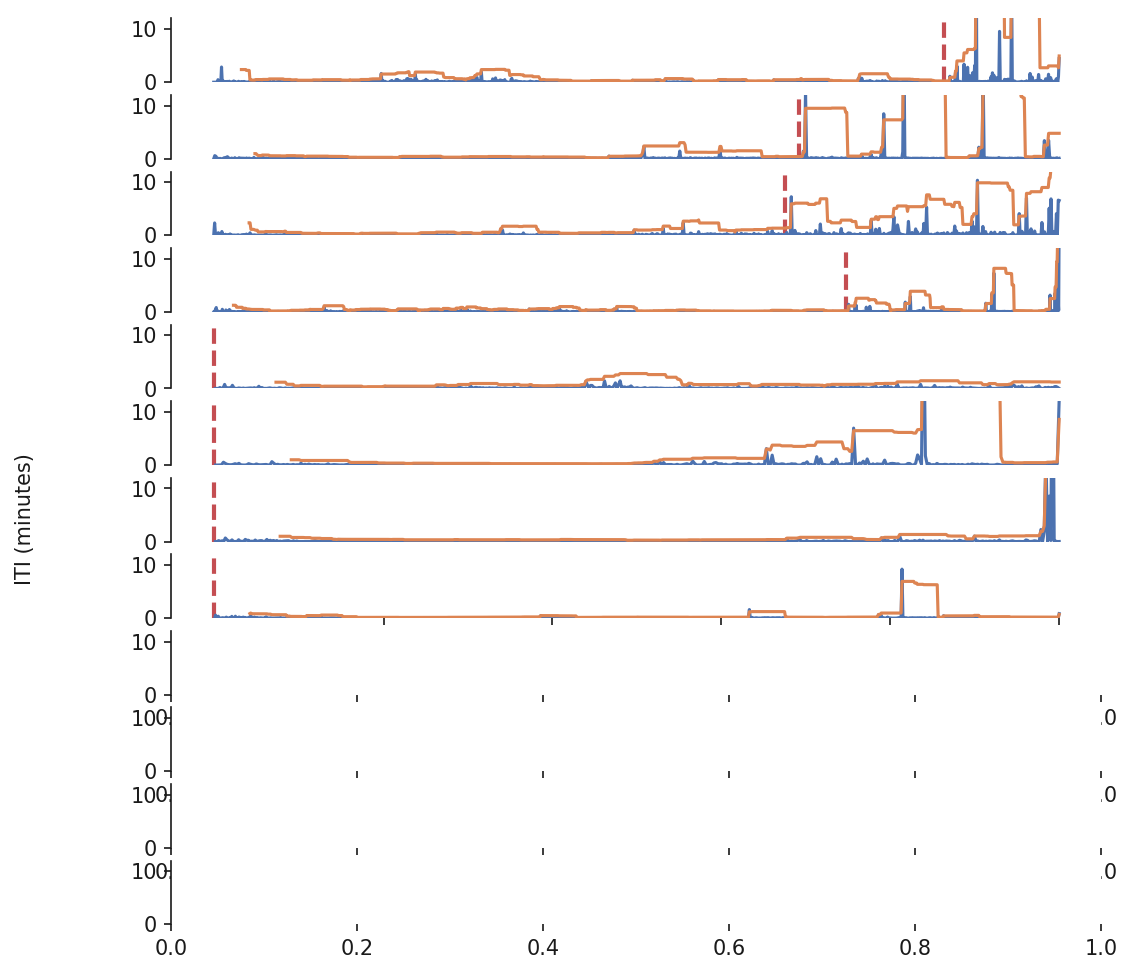

In [526]:
cps = [1030, 555, 630, 1250,0,0,0,0,0,0,0,0]
fig, ax = plt.subplots(12, 1, figsize=(8,8), dpi=150, sharey=True)
for i, rat in enumerate(SHORTCUTS['groups']['day1']):
    iti = bhv[rat]['intertrial_interval']
    (iti/60).plot(ax=ax[i]);
    (2*(iti/60).rolling(40).apply(meanmax)).plot(ax=ax[i])
#     ax[i].set_ylim(0,10)
    ax[i].vlines(cps[i], 0, 600, color='r', linestyle='--', linewidth=2)
    sns.despine(bottom=True)
    if i<7:
        plt.sca(ax[i])
        plt.xticks([])
        plt.xlabel('')
    else:
        plt.sca(ax[i])
        idxs = list(zip(*[(pd.Series(iti.index).quantile(i), int(i*100)) for i in [.2,.4,.6,.8,1]]))
        plt.xticks(idxs[0], idxs[1])
        plt.xlabel('% of Session')
        plt.grid(False, axis='x')
        
plt.ylim(0,12)
plt.yticks([0,10])

plt.text(-220, 28, 'ITI (minutes)', rotation=90)
# plt.savefig('reports/figures/iti_black.png', dpi=150, transparent=True, bbox='tight')

In [417]:
bhv[rat].intertrial_interval.max()

1125.2081050872803

In [403]:
IQR = bhv[rat].intertrial_interval.quantile(.75) - bhv[rat].intertrial_interval.quantile(.25)

0.0015974044799804688
0.01990652084350586
0.0013926029205322266
0.004341840744018555


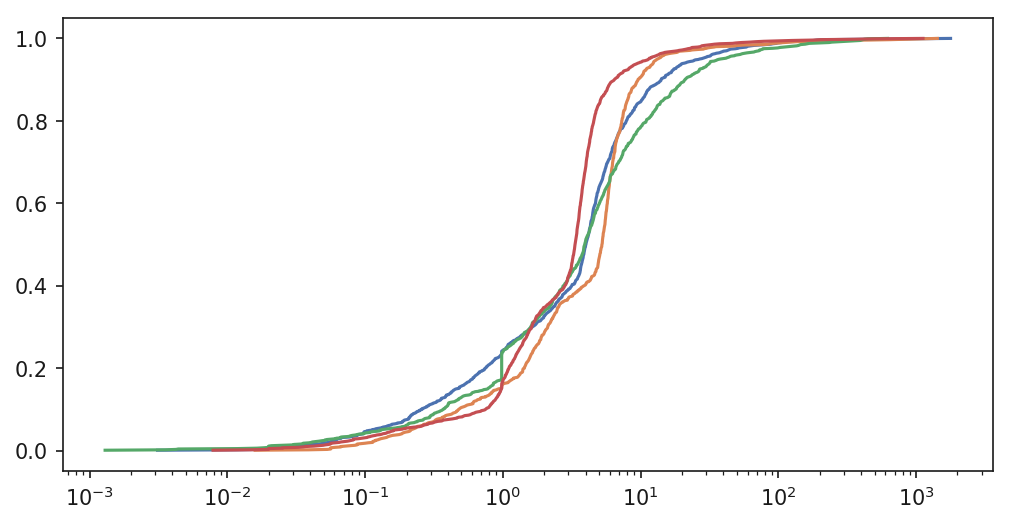

In [414]:
fig, ax = plt.subplots(1, 1, figsize=(8,4), dpi=150)
for i, rat in enumerate(['DRRD 7', 'DRRD 8', 'DRRD 9', 'DRRD 10']):
    qiti = [( bhv[rat].intertrial_interval.quantile(i), i) for i in np.arange(0.001, 1.001, 0.001)]
    print(bhv[rat].intertrial_interval[1:].min())
    plt.semilogx(*zip(*qiti))

In [421]:
bhv[rat]['logiti'] =  bhv[rat].intertrial_interval.apply(np.log10)

In [528]:
allr = pd.concat(bhv.values())

/disk1/home/svo6059/anaconda3/envs/chatbot_v2/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [533]:
allr.intertrial_interval.sort_values(ascending=False)//60

trial
505     47.0
366     32.0
1075    29.0
654     23.0
1671    18.0
1125    18.0
501     17.0
729     16.0
561     12.0
436     12.0
842     10.0
1668     9.0
1108     9.0
762      9.0
503      8.0
635      8.0
1666     7.0
1542     7.0
637      7.0
896      7.0
330      6.0
923      6.0
931      6.0
932      6.0
786      5.0
921      5.0
1192     4.0
929      4.0
888      4.0
1663     3.0
        ... 
8        0.0
540      0.0
72       0.0
454      0.0
565      0.0
361      0.0
295      0.0
314      0.0
758      0.0
382      0.0
538      0.0
496      0.0
8        0.0
886      0.0
384      0.0
408      0.0
254      0.0
162      0.0
118      0.0
90       0.0
2        0.0
1       -0.0
1       -0.0
1       -0.0
339     -0.0
1       -0.0
1       -0.0
1       -0.0
1       -0.0
1       -0.0
Name: intertrial_interval, Length: 7020, dtype: float64

In [515]:
allr[allr.rat==4]

duration  intertrial_interval  is_tired       offset        onset  rat
trial                                                                        
1      0.157967             0.000000     False  3735.380067  3735.222100    4
2      1.462133             0.000033     False  3736.842233  3735.380100    4
3      1.307200             1.369967     False  3739.519400  3738.212200    4
4      0.924133             1.816633     False  3742.260167  3741.336033    4
5      1.681867            32.029933     False  3775.971967  3774.290100    4
6      0.678833            17.558967     False  3794.209767  3793.530933    4
7      0.127800             7.015733     False  3801.353300  3801.225500    4
8      0.655167             3.699767     False  3805.708233  3805.053067    4
9      0.625767             2.974467     False  3809.308467  3808.682700    4
10     1.232500             7.283400     False  3817.824367  3816.591867    4
11     0.216133            14.959333     False  3832.999833  3832.783700    4
12     2.693000             8.214833     False  3843.907667  3841.214667    4
13     0.763233            18.991900     False  3863.662800  3862.899567    4
14     1.199733             2.510500     False  3867.373033  3866.173300    4
15     1.035300             0.621000     False  3869.029333  3867.994033    4
16     1.196067             0.067400     False  3870.292800  3869.096733    4
17     2.204467             2.211900     False  3874.709167  3872.504700    4
18     1.615633            15.247433     False  3891.572233  3889.956600    4
19     1.561067             8.260133     False  3901.393433  3899.832367    4
20     0.366333             3.342333     False  3905.102100  3904.735767    4
21     3.827633             2.283667     False  3911.213400  3907.385767    4
22     0.274233            12.213500     False  3923.701133  3923.426900    4
23     0.508833             4.318767     False  3928.528733  3928.019900    4
24     3.339233             2.374667     False  3934.242633  3930.903400    4
25     1.812267             3.629067     False  3939.683967  3937.871700    4
26     1.875400             6.092867     False  3947.652233  3945.776833    4
27     0.483167             6.346200     False  3954.481600  3953.998433    4
28     0.362633             1.500267     False  3956.344500  3955.981867    4
29     0.379300             1.786200     False  3958.510000  3958.130700    4
30     2.412700            37.945600     False  3998.868300  3996.455600    4
...         ...                  ...       ...          ...          ...  ...
352    4.772333             2.174267     False  6906.711500  6901.939167    4
353    1.890233             1.595333     False  6910.197067  6908.306833    4
354    1.784233             5.418633     False  6917.399933  6915.615700    4
355    1.291667             1.720300     False  6920.411900  6919.120233    4
356    0.265133             1.541233     False  6922.218267  6921.953133    4
357    4.538300             7.455200     False  6934.211767  6929.673467    4
358    1.914500             6.301233     False  6942.427500  6940.513000    4
359    0.128133             6.192067     False  6948.747700  6948.619567    4
360    2.088933             0.002400     False  6950.839033  6948.750100    4
361    1.417400             9.288500     False  6961.544933  6960.127533    4
362    3.251733             1.061133     False  6965.857800  6962.606067    4
363    1.485300             7.113867     False  6974.456967  6972.971667    4
364    2.177200             1.737933     False  6978.372100  6976.194900    4
365    1.422467            13.383067     False  6993.177633  6991.755167    4
366    0.227833             0.972667     False  6994.378133  6994.150300    4
367    3.275000             0.082400     False  6997.735533  6994.460533    4
368    3.019700            11.477267     False  7012.232500  7009.212800    4
369    0.354867            11.744233     False  7024.331600  7023.976733    4
370    1.009433             0

/disk1/home/svo6059/anaconda3/envs/chatbot_v2/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


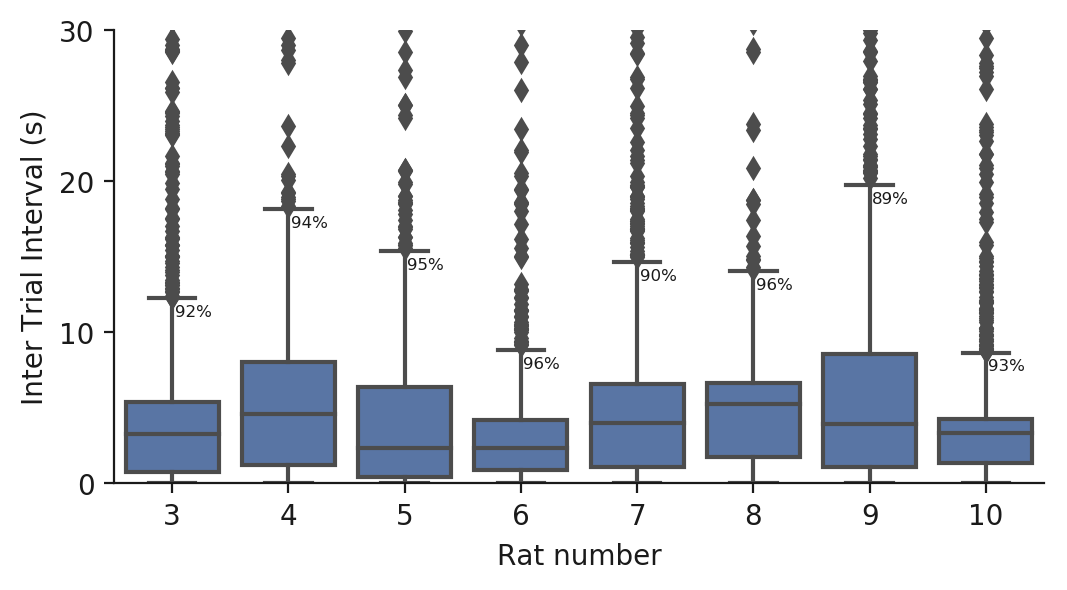

In [510]:
plt.figure(figsize=(6,3), dpi=200)
ax = sns.boxplot(y='intertrial_interval', x='rat', data = pd.concat(bhv.values()), color='b')
plt.ylim(0,30)
plt.ylabel('Inter Trial Interval (s)')
plt.xlabel('Rat number')
for rat in range(3,11):
    rdf = allr[allr.rat==rat]
    Q3 = rdf.intertrial_interval.quantile(.75)
    IQR = Q3 - rdf.intertrial_interval.quantile(.25)
    inside = (rdf.intertrial_interval < (Q3 + 1.5*IQR))
    ax.text(rat-3+.02, rdf[inside].intertrial_interval.max() - 1.2, 
            '{:.0%}'.format(inside.mean()), fontsize=6)
plt.yticks([0, 10, 20, 30])
sns.despine()

0.0015974044799804688
0.01990652084350586
0.0013926029205322266
0.004341840744018555
0.017299999999522697
0.0
0.0005999999993946403
0.0015999999995983671


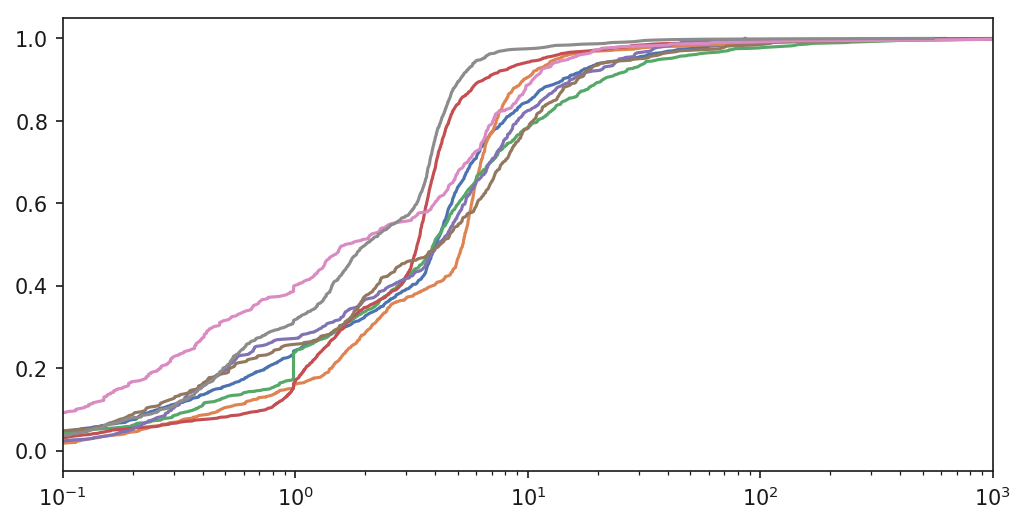

In [448]:
fig, ax = plt.subplots(1, 1, figsize=(8,4), dpi=150)
for rat in SHORTCUTS['groups']['day1']:
    qiti = [( bhv[rat].intertrial_interval.quantile(i), i) for i in np.arange(0.001, 1.001, 0.001)]
    print(bhv[rat].intertrial_interval[1:].min())
    plt.semilogx(*zip(*qiti))
    plt.xlim(.1,1e3)

In [90]:
100*iti.index/iti.index.max()

Float64Index([0.059844404548174746,  0.11968880909634949,  0.17953321364452424,
               0.23937761819269898,   0.2992220227408737,   0.3590664272890485,
                0.4189108318372232,  0.47875523638539796,   0.5385996409335727,
                0.5984440454817475,
              ...
                 99.46140035906643,     99.5212447636146,    99.58108916816278,
                 99.64093357271095,    99.70077797725912,     99.7606223818073,
                 99.82046678635548,    99.88031119090365,    99.94015559545183,
                             100.0],
             dtype='float64', name='trial', length=1671)

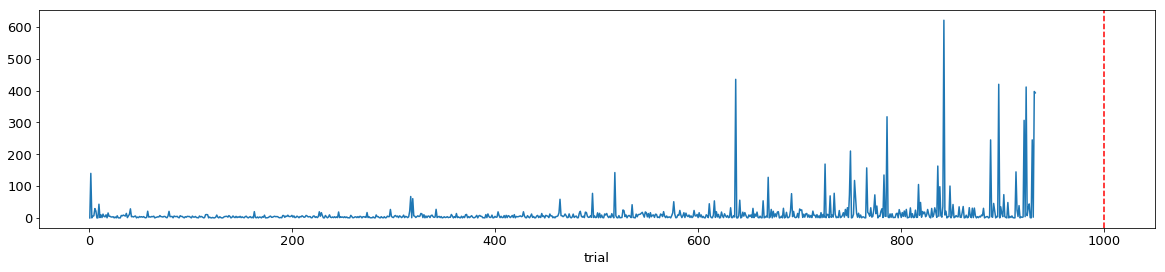

In [45]:
rat = 'DRRD 9'
bhv[rat]['intertrial_interval'].plot();

# My choice for cropping the session
plt.axvline(1000, linestyle='--', color='r')

# Stationary analysis

In [389]:
def detrend_VAR(arr):
    d = var_model.VAR(arr)
    order = d.select_order(20)
    res = d.fit(order['bic'])
    residuals = arr[order['bic']:] - res.fittedvalues
    return residuals

In [390]:
def detrend_VARMAX(arr, exog=None):
    d = var_model.VAR(arr)
    order = d.select_order(20)
    
    vmax = VARMAX(arr, exog, (order['bic'], 2), enforce_stationarity=False)
    res = vmax.fit(maxiter=200)
    residuals = arr - res.fittedvalues
    return residuals

In [391]:
bhv[rat]['rewarded'] = np.hstack((0, (bhv[rat]['duration']>1.5).values[:-1] ))

In [392]:
residuals = detrend_VAR(bhv[rat][['duration','intertrial_interval', 'rewarded']].values)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         2.810        2.825        16.61        2.816
1         1.970        2.030        7.172        1.993
2         1.922       2.027*        6.836        1.962
3         1.902        2.052        6.700        1.959
4         1.883        2.078        6.575       1.957*
5         1.888        2.127        6.607        1.979
6        1.855*        2.139       6.391*        1.963
7         1.859        2.188        6.417        1.984
8         1.861        2.235        6.433        2.004
9         1.872        2.291        6.503        2.032
10        1.869        2.333        6.481        2.045
11        1.877        2.385        6.533        2.070
12        1.892        2.445        6.631        2.102
13        1.900        2.499        6.689        2.128
14        1.910        2.553        6.755        2.155
15        

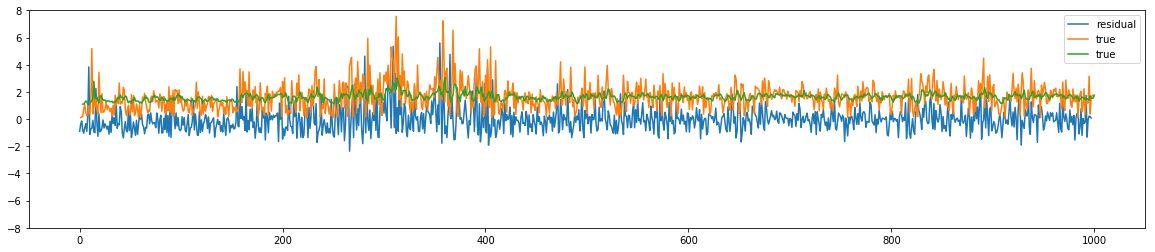

In [401]:
plt.plot(residuals[:,0], label='residual'); plt.ylim(-8,8)
plt.plot(bhv[rat]['duration'], label='true'); plt.ylim(-8,8)
plt.plot(bhv[rat]['duration'][2:]-residuals[:,0], label='true'); plt.ylim(-8,8)
#plt.plot(residuals[:,1], label='ITI',alpha=.5); 
plt.legend()

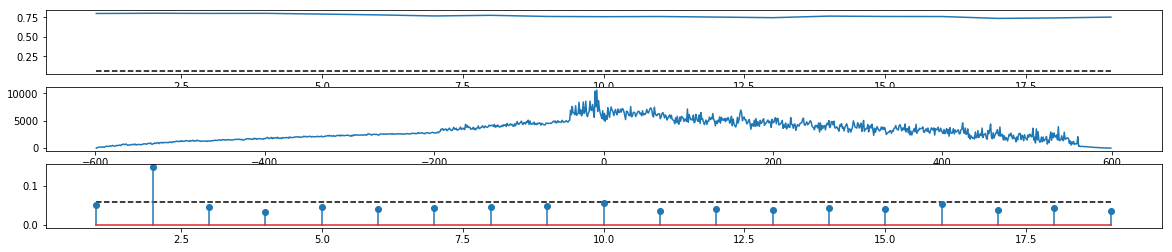

In [382]:
acorr = np.correlate(bhv[rat]['intertrial_interval'], bhv[rat]['intertrial_interval'], 2)
acorr /= acorr.max()
xcorr = np.correlate(bhv[rat]['intertrial_interval'], bhv[rat]['duration'], 2)
x = np.arange(-bhv[rat].shape[0]+1,bhv[rat].shape[0])
to_plot = np.logical_and(x>0, x<20)
dcorr = np.correlate(bhv[rat]['duration'], bhv[rat]['duration'], 2)
dcorr /= dcorr.max()


plt.subplot(3,1,1)
plt.plot(x[to_plot],dcorr[to_plot]);
plt.hlines(2/np.sqrt(len(acorr/2)),x[to_plot][0], x[to_plot][-1], linestyles='--')
plt.subplot(3,1,2)
plt.plot(x,xcorr);
plt.subplot(3,1,3)
plt.stem(x[to_plot], acorr[to_plot]);
plt.hlines(2/np.sqrt(len(acorr/2)),x[to_plot][0], x[to_plot][-1], linestyles='--')

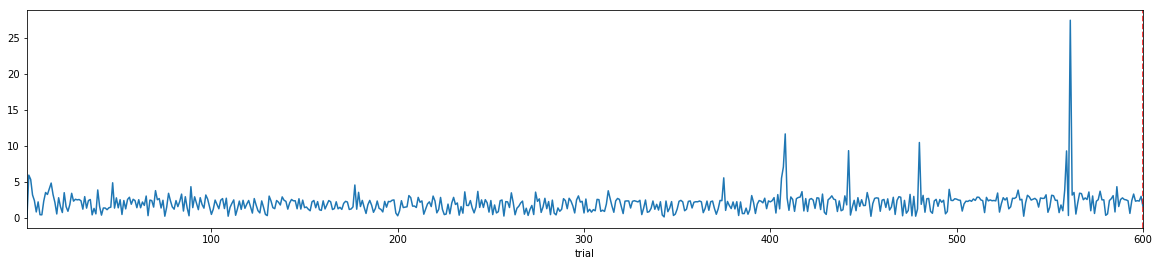

In [402]:
rat = 'DRRD 8'
bhv[rat]['intertrial_interval'].apply(np.sqrt).plot()

# My choice for cropping the session
plt.axvline(600, linestyle='--', color='r')

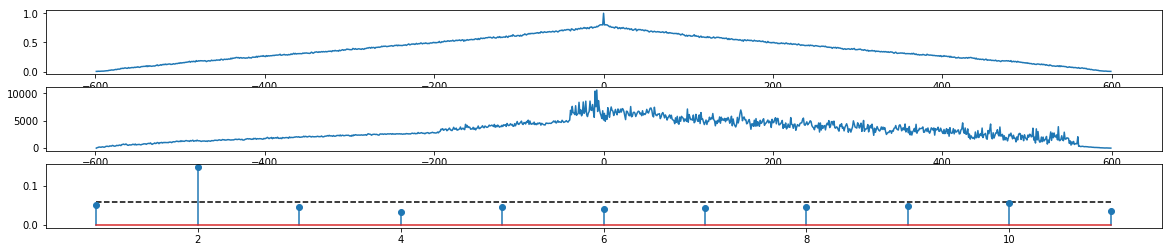

In [403]:
acorr = np.correlate(bhv[rat]['intertrial_interval'], bhv[rat]['intertrial_interval'], 2)
acorr /= acorr.max()
xcorr = np.correlate(bhv[rat]['intertrial_interval'], bhv[rat]['duration'], 2)
x = np.arange(-bhv[rat].shape[0]+1,bhv[rat].shape[0])
to_plot = np.logical_and(x>0, x<12)
dcorr = np.correlate(bhv[rat]['duration'], bhv[rat]['duration'], 2)
dcorr /= dcorr.max()


plt.subplot(3,1,1)
plt.plot(x,dcorr);
plt.subplot(3,1,2)
plt.plot(x,xcorr);
plt.subplot(3,1,3)
plt.stem(x[to_plot], acorr[to_plot]);
plt.hlines(2/np.sqrt(len(acorr/2)),x[to_plot][0], x[to_plot][-1], linestyles='--')

In [404]:
bhv[rat]['rewarded'] = np.hstack((0, (bhv[rat]['duration']>1.5).values[:-1] ))
residuals = detrend_VAR(bhv[rat][['duration','intertrial_interval', 'rewarded']].values)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         5.309        5.332        202.2        5.318
1         4.518       4.609*        91.68        4.554
2         4.489        4.646        88.99       4.550*
3         4.498        4.724        89.84        4.586
4         4.519        4.812        91.70        4.633
5         4.521        4.882        91.96        4.662
6         4.520        4.948        91.81        4.687
7         4.522        5.019        92.05        4.716
8         4.465        5.029        86.89        4.684
9         4.458        5.090        86.32        4.704
10        4.440        5.139        84.79        4.713
11       4.413*        5.180       82.55*        4.712
12        4.427        5.262        83.74        4.753
13        4.436        5.339        84.50        4.788
14        4.451        5.422        85.82        4.830
15        

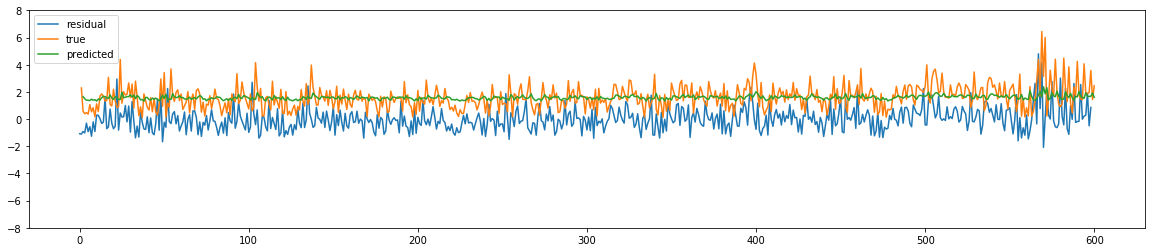

In [407]:
plt.plot(residuals[:,0], label='residual'); plt.ylim(-8,8)
plt.plot(bhv[rat]['duration'], label='true'); plt.ylim(-8,8)
plt.plot(bhv[rat]['duration'][1:]-residuals[:,0], label='predicted'); plt.ylim(-8,8)
#plt.plot(residuals[:,1], label='ITI',alpha=.5); 
plt.legend()

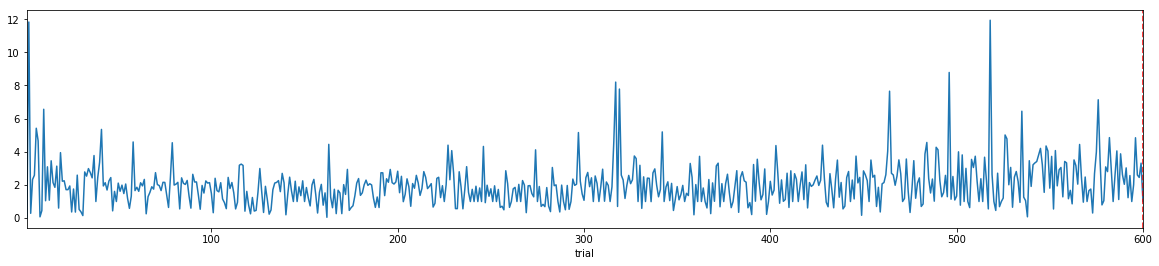

In [408]:
rat = 'DRRD 9'
bhv[rat]['intertrial_interval'].apply(np.sqrt).plot()

# My choice for cropping the session
plt.axvline(600, linestyle='--', color='r')

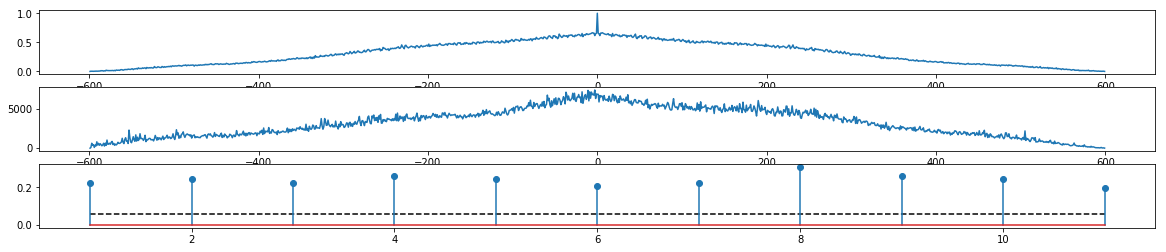

In [409]:
acorr = np.correlate(bhv[rat]['intertrial_interval'], bhv[rat]['intertrial_interval'], 2)
acorr /= acorr.max()
xcorr = np.correlate(bhv[rat]['intertrial_interval'], bhv[rat]['duration'], 2)
x = np.arange(-bhv[rat].shape[0]+1,bhv[rat].shape[0])
to_plot = np.logical_and(x>0, x<12)
dcorr = np.correlate(bhv[rat]['duration'], bhv[rat]['duration'], 2)
dcorr /= dcorr.max()


plt.subplot(3,1,1)
plt.plot(x,dcorr);
plt.subplot(3,1,2)
plt.plot(x,xcorr);
plt.subplot(3,1,3)
plt.stem(x[to_plot], acorr[to_plot]);
plt.hlines(2/np.sqrt(len(acorr/2)),x[to_plot][0], x[to_plot][-1], linestyles='--')

In [410]:
bhv[rat]['rewarded'] = np.hstack((0, (bhv[rat]['duration']>1.5).values[:-1] ))
residuals = detrend_VAR(bhv[rat][['duration','intertrial_interval', 'rewarded']].values)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         3.818        3.841        45.53        3.827
1        3.156*       3.246*       23.48*       3.191*
2         3.171        3.329        23.84        3.233
3         3.183        3.409        24.13        3.271
4         3.178        3.471        24.00        3.292
5         3.184        3.545        24.15        3.325
6         3.204        3.633        24.64        3.371
7         3.217        3.714        24.96        3.411
8         3.227        3.791        25.21        3.447
9         3.232        3.864        25.33        3.478
10        3.250        3.950        25.80        3.523
11        3.272        4.039        26.37        3.571
12        3.290        4.125        26.85        3.615
13        3.300        4.203        27.13        3.652
14        3.323        4.293        27.76        3.701
15        

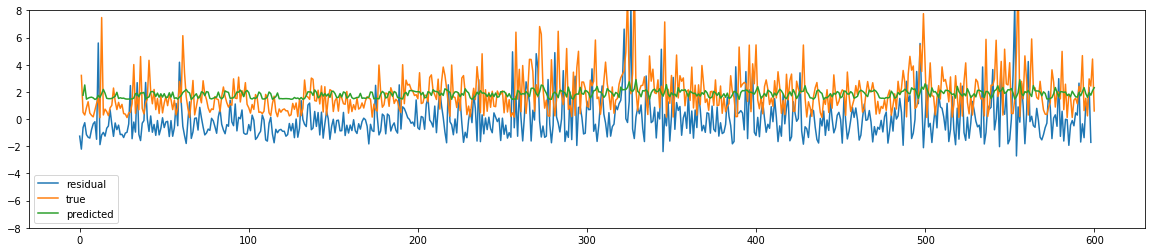

In [412]:
plt.plot(residuals[:,0], label='residual'); plt.ylim(-8,8)
plt.plot(bhv[rat]['duration'], label='true'); plt.ylim(-8,8)
plt.plot(bhv[rat]['duration'][1:]-residuals[:,0], label='predicted'); plt.ylim(-8,8)
#plt.plot(residuals[:,1], label='ITI',alpha=.5); 
plt.legend()

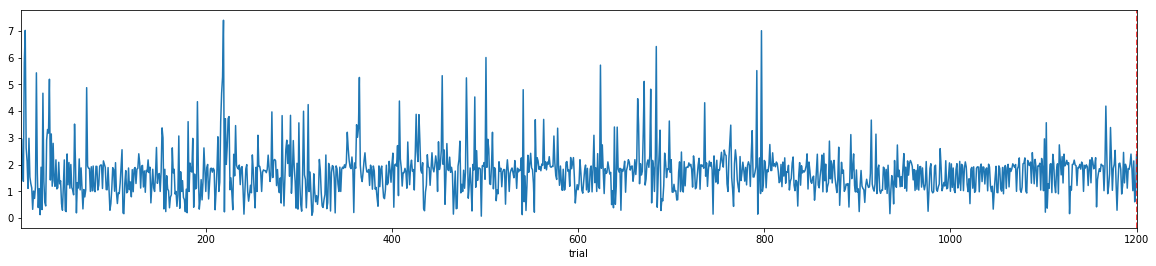

In [413]:
rat = 'DRRD 10'
bhv[rat]['intertrial_interval'].apply(np.sqrt).plot()

# My choice for cropping the session
plt.axvline(1200, linestyle='--', color='r')

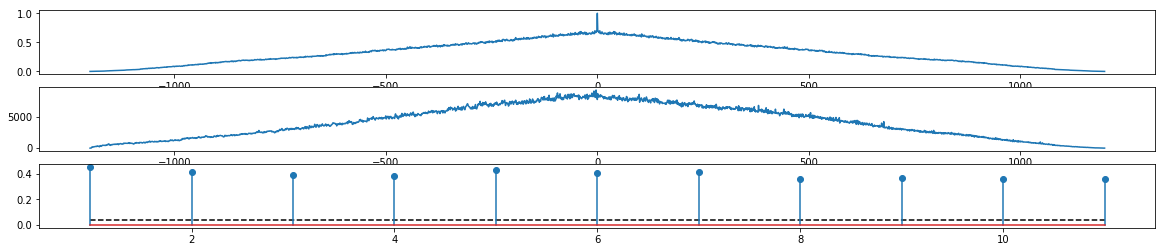

In [414]:
acorr = np.correlate(bhv[rat]['intertrial_interval'], bhv[rat]['intertrial_interval'], 2)
acorr /= acorr.max()
xcorr = np.correlate(bhv[rat]['intertrial_interval'], bhv[rat]['duration'], 2)
x = np.arange(-bhv[rat].shape[0]+1,bhv[rat].shape[0])
to_plot = np.logical_and(x>0, x<12)
dcorr = np.correlate(bhv[rat]['duration'], bhv[rat]['duration'], 2)
dcorr /= dcorr.max()


plt.subplot(3,1,1)
plt.plot(x,dcorr);
plt.subplot(3,1,2)
plt.plot(x,xcorr);
plt.subplot(3,1,3)
plt.stem(x[to_plot], acorr[to_plot]);
plt.hlines(2/np.sqrt(len(acorr/2)),x[to_plot][0], x[to_plot][-1], linestyles='--')

In [415]:
bhv[rat]['rewarded'] = np.hstack((0, (bhv[rat]['duration']>1.5).values[:-1] ))
residuals = detrend_VAR(bhv[rat][['duration','intertrial_interval', 'rewarded']].values)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0         2.264        2.277        9.624        2.269
1         1.826       1.878*        6.209       1.845*
2         1.814        1.905        6.138        1.849
3         1.800        1.929        6.048        1.848
4         1.802        1.970        6.063        1.865
5         1.781        1.988        5.938        1.859
6         1.775        2.020        5.898        1.867
7         1.773        2.056        5.886        1.880
8        1.771*        2.094       5.878*        1.893
9         1.775        2.136        5.898        1.911
10        1.786        2.186        5.966        1.937
11        1.789        2.228        5.986        1.955
12        1.798        2.276        6.040        1.978
13        1.804        2.320        6.072        1.998
14        1.814        2.368        6.133        2.023
15        

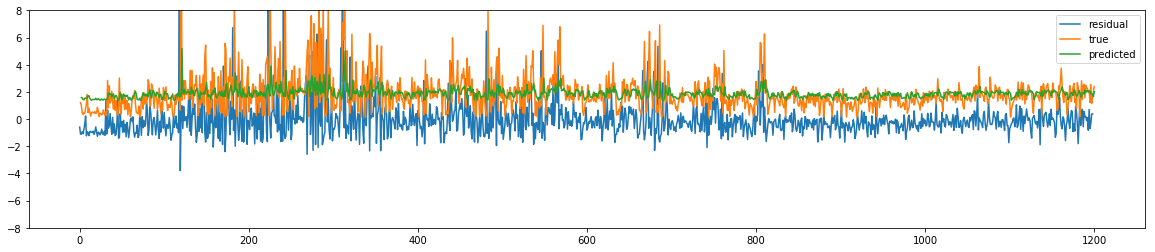

In [416]:
plt.plot(residuals[:,0], label='residual'); plt.ylim(-8,8)
plt.plot(bhv[rat]['duration'], label='true'); plt.ylim(-8,8)
plt.plot(bhv[rat]['duration'][1:]-residuals[:,0], label='predicted'); plt.ylim(-8,8)
#plt.plot(residuals[:,1], label='ITI',alpha=.5); 
plt.legend()

# Hidden Markov Model

In [4]:
from hmmlearn.hmm import GaussianHMM, GMMHMM

In [7]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [8]:
from spikelearn.data import SHORTCUTS

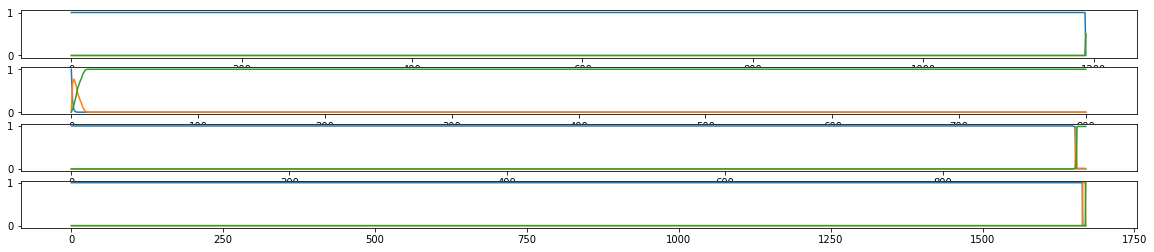

In [10]:
for i, label in enumerate(SHORTCUTS['groups']['DRRD']):
    t = io.load(label, 'behav_stats')[['duration','intertrial_interval']].values.reshape(-1,2)

    model = GaussianHMM(3, params='smc', init_params="scm", covariance_type='tied')
    model.transmat_=np.array([[1./3,1./3,1./3],[0,.5,.5],[0,0,1]]) 
    model.fit(t)

    plt.subplot(4,1,i+1)
    plt.plot(model.predict_proba(t))
    #plt.xlim([0,0])

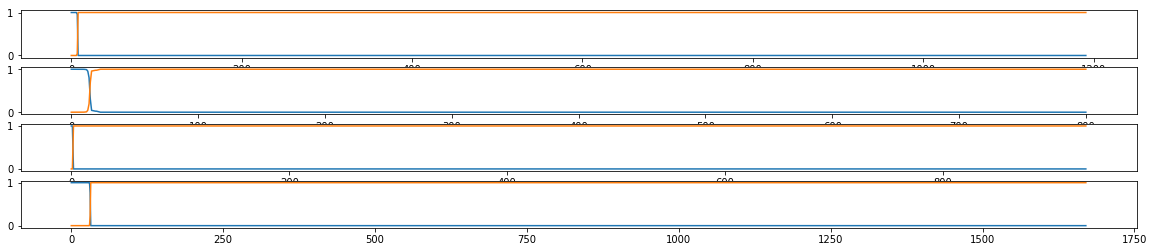

In [13]:
for i, label in enumerate(SHORTCUTS['groups']['DRRD']):
    t = io.load(label, 'behav_stats')[['duration','intertrial_interval']].values.reshape(-1,2)

    model = GMMHMM(2, 2, params='smc', init_params="scm", covariance_type='diag')
    model.transmat_=np.array([[.5,.5],[0,1]]) 
    model.fit(t)

    plt.subplot(4,1,i+1)
    plt.plot(model.predict_proba(t))
    #plt.xlim([0,0])

onset        offset  duration  intertrial_interval  is_tired  \
trial                                                                        
1        105.777193    106.990264  1.213071             0.000000     False   
2        115.756114    116.750828  0.994714             8.765850     False   
3        119.935959    120.397332  0.461373             3.185132     False   
4        122.270556    122.600407  0.329851             1.873224     False   
5        156.328469    156.804874  0.476406            33.728061     False   
6        206.114161    206.560993  0.446833            49.309286     False   
7        213.447516    214.244557  0.797041             6.886523     False   
8        218.731151    219.864474  1.133322             4.486594     False   
9        221.086966    222.890721  1.803756             1.222492     False   
10       231.783752    232.256594  0.472842             8.893030     False   
11       234.608763    235.402813  0.794050             2.352169     False   
12       237.057434    237.573079  0.515646             1.654620     False   
13       238.832026    239.059558  0.227533             1.258946     False   
14       239.162778    239.635702  0.472924             0.103219     False   
15       240.644751    241.169326  0.524575             1.009050     False   
16       241.699471    242.178089  0.478617             0.530145     False   
17       243.504742    243.951616  0.446874             1.326653     False   
18       273.462927    274.011341  0.548414            29.511311     False   
19       276.821647    277.227274  0.405627             2.810307     False   
20       277.377352    277.859779  0.482427             0.150078     False   
21       279.061463    279.920353  0.858890             1.201684     False   
22       279.935099    280.527258  0.592159             0.014746     False   
23       284.128870    284.317286  0.188416             3.601613     False   
24       284.415304    284.840100  0.424796             0.098017     False   
25       306.646712    307.065569  0.418857            21.806612     False   
26       308.964844    309.280932  0.316088             1.899274     False   
27       309.618442    309.965742  0.347300             0.337510     False   
28       310.167880    310.838149  0.670269             0.202137     False   
29       319.364506    319.802122  0.437617             8.526356     False   
30       330.764861    331.064525  0.299664            10.962739     False   
...             ...           ...       ...                  ...       ...   
1642   10770.748293  10775.308861  4.560568             3.231744      True   
1643   10788.485407  10788.854456  0.369050            13.176545      True   
1644   10789.213798  10790.066176  0.852378             0.359342      True   
1645   10812.748636  10815.471903  2.723266            22.682460      True   
1646   10821.535089  10823.864975  2.329887             6.063186      True   
1647   10828.468347  10832.571720  4.103373             4.603371      True   
1648   10837.144986  10839.703839  2.558853             4.573266      True   
1649   10842.916250  10845.529866  2.613617             3.212411      True   
1650   10850.455019  10853.859328  3.404309             4.925153      True   
1651   10858.189947  10864.904520  6.714573             4.330619      True   
1652   10871.903682  10873.876808  1.973125             6.999163      True   
1653   11063.305462  11064.582758  1.277297           189.428654      True   
1654   11066.290463  11067.801805  1.511342             1.707704      True   
1655   11068.327772  11070.740931  2.413158             0.525967      True   
1656   11076.552130  11080.481055  3.928924             5.811200      True   
1657   11094.532178  11094.755492  0.223314            14.051123      True   
1658   11095.546962  11097.763349  2.216387             0.791470      True   
1659   11104.828129  11105.007165  0.179036             7.064781      True   
1660   11105.298882  11106.799165  1

/home/tevo/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py:460: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/home/tevo/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py:469: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),
/home/tevo/anaconda3/lib/python3.6/site-packages/hmmlearn/base.py:624: RuntimeWarning: divide by zero encountered in log
  np.log(self.transmat_),


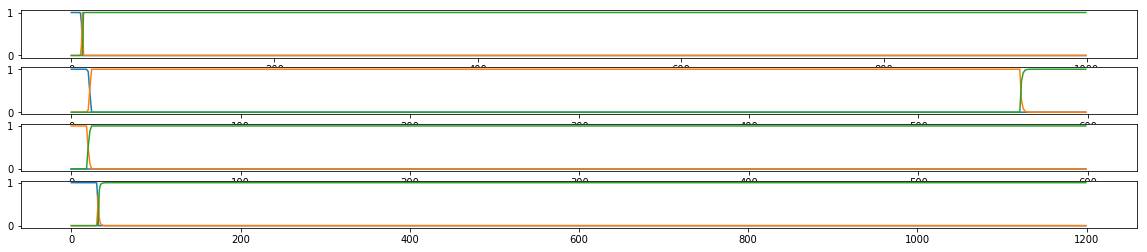

In [309]:
X, lengths = np.full((0,3), 1), []
for i, label in enumerate(SHORTCUTS['groups']['DRRD']):
    t = io.load(label, 'behav_stats')
    t = t.join(t.shift().duration, rsuffix=' prev')
    t = select(t, is_tired=False)[['duration', 'duration prev', 'intertrial_interval']].values.reshape(-1,3)
    
    X = np.nan_to_num(np.vstack((X, t)))
    lengths.append(t.shape[0])
    
model = GMMHMM(3, params='stmc', init_params="sc", covariance_type='diag', n_iter=1000)
model.gmms_[0].means_ = np.array([[.1,.1, 10]])
model.gmms_[0].means_ = np.array([[1.6,1.6, 10]])
 
#model.transmat_= np.array([[.1,.9],[0,1]]) 
model.transmat_ = np.array([[.2,.8,0],[0,.8,.2],[0,0,1]])
model.fit(X, lengths)


for i, label in enumerate(SHORTCUTS['groups']['DRRD']):
    t = io.load(label, 'behav_stats')
    t = t.join(t.shift().duration, rsuffix=' prev')
    t = np.nan_to_num(select(t, is_tired=False)[['duration', 'duration prev', 'intertrial_interval']].values.reshape(-1,3))
    
    plt.subplot(4,1,i+1)
    plt.plot(model.predict_proba(t))

#plt.xlim([0,0])

In [310]:
model.transmat_

array([[ 0.94422442,  0.05577558,  0.        ],
       [ 0.        ,  0.99289862,  0.00710138],
       [ 0.        ,  0.        ,  1.        ]])

In [314]:
for i in range(3):
    print(model.gmms_[i].means_)
    print(model.gmms_[i].covars_)

[[ 0.61827161  0.56949056  7.14021069]]
[[   0.17355793    0.17144029  121.45503631]]
[[ 1.5461062   1.53507425  7.27882239]]
[[  6.55386876e-01   6.34221477e-01   1.16700542e+03]]
[[ 1.8122849   1.81285963  4.74296375]]
[[  1.70134463   1.70607652  54.86597917]]


In [313]:
model.covars_

AttributeError: 'GMMHMM' object has no attribute 'covars_'

In [312]:
a = model.gmms_[0]

In [315]:
a.covars_

array([[   0.17355793,    0.17144029,  121.45503631]])

In [61]:
model.gmms_[0]

SyntaxError: invalid syntax (<ipython-input-61-f7942394a5bf>, line 1)

In [65]:
model.gmms_[0].means_

array([[  0.50838001,   0.90779372],
       [  0.81800029,  14.55084921]])

In [68]:
model.gmms_[1].means_

array([[  1.66512961,   3.38453811],
       [  2.91614707,  42.68544102]])

---

In [190]:
b = select(io.load('DRRD 10', 'behav_stats'), is_tired =False)
#b = io.load('DRRD 10', 'behav_stats')
b['rewarded'] = (b.duration>1.5)

window = 30

y = b.rewarded.rolling(window).apply(dprime)[window:]
x = b.index[window:]

In [130]:
from scipy.optimize import curve_fit
from sklearn.metrics import explained_variance_score
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def dprime(pred):
    TP = pred.astype(int).sum()/len(pred)
    FP = (pred==False).astype(int).sum()/len(pred)
    return (norm.ppf(TP) - norm.ppf(FP))

def degrau(x, baixo, alto, th):
    return baixo*((x<th).astype(int)) + alto*((x>=th).astype(int))

def best_degrau(x, y):
    ths = x[2:-2]
    scores = np.array([((y - degrau(x, y[x<th].mean(), y[x>=th].mean(), th))**2).sum() for th in ths])
    th = ths[scores.argmin()]
    return y[x<th].mean(), y[x>=th].mean(), th
        
def compare_linear_vs_step(x,y, plot=True, return_raw = False):
    a, b = np.polyfit(x,y,1)
    linear_pred = a*x + b
    r_lin = explained_variance_score(y, linear_pred)

    #pars, _ = curve_fit(degrau, x, y, p0=[-.2,1,100], method='trf')
    step_pred = degrau(x, *best_degrau(x, y))
    r_step = explained_variance_score(y, step_pred)

    if plot:
        plt.plot(x,y, label='D prime')
        plt.plot(x, linear_pred, label= 'Regression, R^2: {:.2f}'.format(r_lin), linewidth=2)
        plt.plot(x, step_pred, label='Step, R^2: {:.2f}'.format(r_step), linewidth=2)
        plt.legend(loc='upper right')
    if return_raw:
        return linear_pred, step_pred
    else:
        return r_lin, r_step

CPU times: user 40 s, sys: 2.73 s, total: 42.8 s
Wall time: 18.7 s


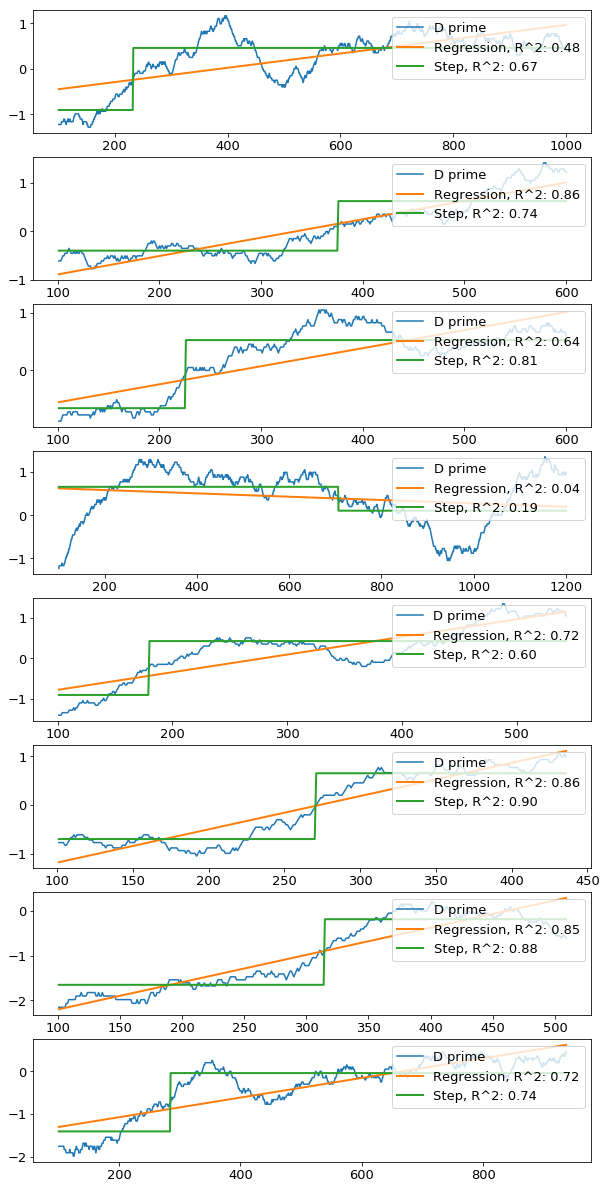

In [127]:
%%time

window = 100
plt.figure(figsize=(10,32))
for i, label in enumerate(SHORTCUTS['groups']['day1']):
    b = select(io.load(label, 'behav_stats'), is_tired =False)
    b['rewarded'] = (b.duration>1.5)

    y = b.rewarded.rolling(window).apply(dprime, raw=True)[window:]
    x = b.index[window:]

    
    plt.subplot(12,1,1+i)
    l, s = compare_linear_vs_step(x, y);

In [131]:
from itertools import product

In [135]:
%%time

res ={}
for w, label in product(np.arange(30,120,20), SHORTCUTS['groups']['day1']):
    b = select(io.load(label, 'behav_stats'), is_tired =False)
    b['rewarded'] = (b.duration>1.5)

    y = b.rewarded.rolling(w).apply(dprime, raw=True)[window:]
    x = b.index[window:]
    try:
        l, s = compare_linear_vs_step(x, y, False);
        res[(w, label, 'linear')] = l
        res[(w, label, 'step')] = s
    except:
        res[(w, label, 'linear')] = np.nan
        res[(w, label, 'step')] = np.nan

/disk1/home/svo6059/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel/__main__.py:22: RankWarning: Polyfit may be poorly conditioned
/disk1/home/svo6059/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel/__main__.py:22: RankWarning: Polyfit may be poorly conditioned
/disk1/home/svo6059/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel/__main__.py:22: RankWarning: Polyfit may be poorly conditioned
/disk1/home/svo6059/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel/__main__.py:22: RankWarning: Polyfit may be poorly conditioned
/disk1/home/svo6059/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel/__main__.py:22: RankWarning: Polyfit may be poorly conditioned
/disk1/home/svo6059/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel/__main__.py:22: RankWarning: Polyfit may be poorly conditioned
/disk1/home/svo6059/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel/__main__.py:22: RankWarning: Polyfit may be poorly conditioned


CPU times: user 2min 50s, sys: 9.9 s, total: 3min
Wall time: 1min 6s


/disk1/home/svo6059/anaconda3/envs/nlp/lib/python3.6/site-packages/ipykernel/__main__.py:22: RankWarning: Polyfit may be poorly conditioned


In [143]:
res = pd.DataFrame(res, index=['exp']).stack().T.reset_index(0)
res.columns = ['window', 'linear', 'step']

In [160]:
res.reset_index().melt(id_vars=['window','index']).set_index(['variable','index']).pivot(columns='window').reset_index(0)

variable     value                                  
window                  30        50        70        90 110
index                                                       
DRRD 10   linear  0.046219  0.050971  0.052192  0.044676 NaN
DRRD 7    linear  0.227417  0.316153  0.390040  0.448897 NaN
DRRD 8    linear  0.533305  0.691533  0.794087  0.843882 NaN
DRRD 9    linear  0.286306  0.427225  0.513052  0.597319 NaN
ELI 3     linear  0.336373  0.504654  0.639650  0.703225 NaN
ELI 4     linear  0.607553  0.717947  0.821690  0.855174 NaN
ELI 5     linear  0.468182  0.663356  0.764765  0.822683 NaN
ELI 6     linear  0.431435  0.560403  0.648767  0.700676 NaN
DRRD 10     step  0.160090  0.189578  0.209219  0.202780 NaN
DRRD 7      step  0.393669  0.503461  0.574966  0.644307 NaN
DRRD 8      step  0.519513  0.598453  0.667164  0.722059 NaN
DRRD 9      step  0.566309  0.702638  0.734530  0.791703 NaN
ELI 3       step  0.358812  0.470611  0.531864  0.573887 NaN
ELI 4       step  0.794002  0.884267  0.918761  0.909756 NaN
ELI 5       step  0.719869  0.855098  0.877801  0.882767 NaN
ELI 6       step  0.447610  0.580821  0.665447  0.725148 NaN

# Final images

In [92]:
for label in SHORTCUTS['groups']['eletro']:
#     fig, ax = plt.subplots(figsize=(4,4))
    dur = select(io.load(label, 'behav_stats'), is_tired=False).reset_index()
    dur['rewarded'] = dur.duration>1.5
    dur['rewarded'] = dur.rewarded.apply(lambda b: 'Rewarded' if b else 'Not rewarded')
    dur['first_half'] = dur.trial < dur.trial.median()
    dur['percent_trial'] = dur.trial/dur.trial.max()*100

In [29]:
sns.set_palette('deep',color_codes=True)

In [77]:
dur.rewarded.value_counts()

Rewarded        382
Not rewarded    317
Name: rewarded, dtype: int64

In [86]:
x = axs.get_legend_handles_labels()
x[0][1:]

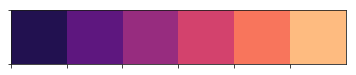

In [138]:
sns.palplot(pal)

In [161]:
plt.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'k',
          'axes.facecolor': 'w',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter

[(<matplotlib.collections.PathCollection at 0x7f9f7316aa58>,
  <matplotlib.collections.PathCollection at 0x7f9f7315e5c0>),
 ('Not rewarded', 'Rewarded')]

/disk1/home/svo6059/anaconda3/envs/chatbot_v2/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[(<matplotlib.lines.Line2D object at 0x7f9f71777f28>,), ('Moving average',)]


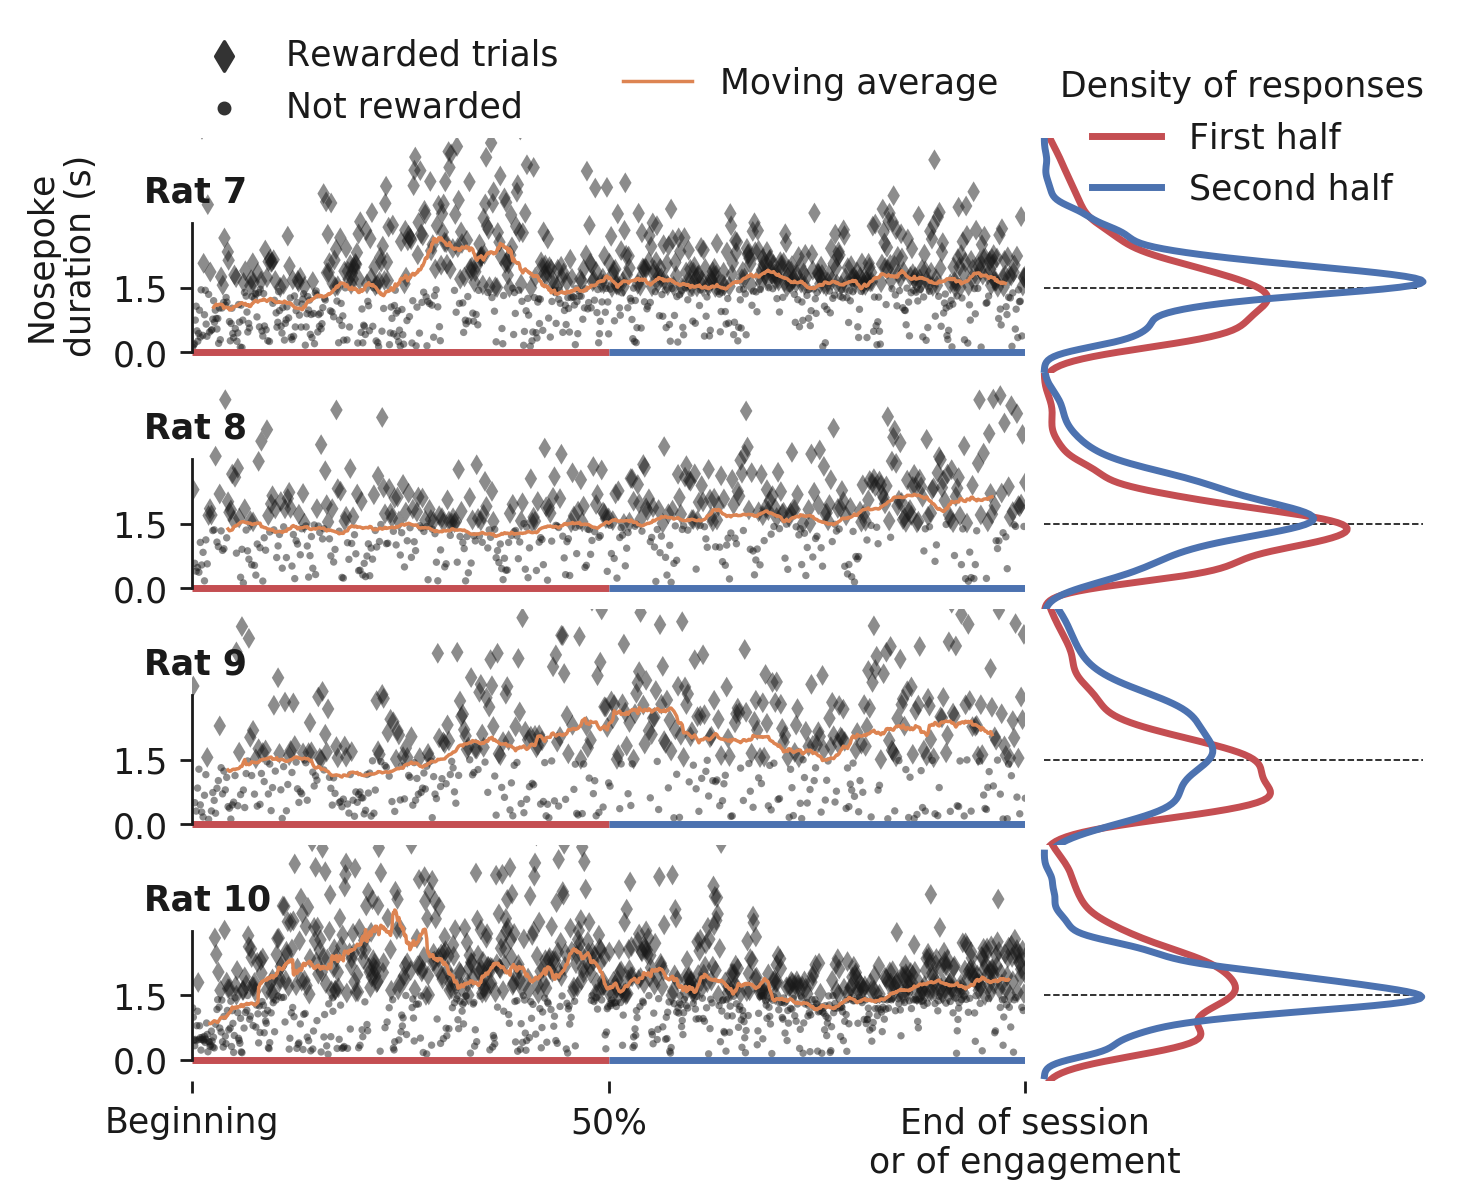

In [370]:
shape = (4,3)
ylim = (-.5, 5)
fig, ax = plt.subplots(*shape, figsize=(5,5), dpi=250)
fig.subplots_adjust(hspace=0, wspace=0, right=1, left=0)
i = 0
for i, label in enumerate(list(SHORTCUTS['groups']['eletro'].keys())[:4]):
#     fig, ax = plt.subplots(figsize=(4,4))

    dur = select(io.load(label, 'behav_stats'), is_tired=False).reset_index()
    dur['rewarded'] = dur.duration>1.5
    dur['rewarded'] = dur.rewarded.apply(lambda b: 'Rewarded trials' if b else 'Not rewarded')
    dur['first_half'] = dur.trial < dur.trial.median()
    dur['percent_trial'] = dur.trial/dur.trial.max()*100
    
    axs = plt.subplot2grid(shape,(i,0), 1, 2)
    sns.scatterplot(y='duration', x='percent_trial', style='rewarded', data=dur, color='k', markers=['.','d'],
                    style_order=['Not rewarded', 'Rewarded trials'], ax=axs, size=3, linewidth=0, alpha=.5)
    dur.set_index('percent_trial').duration.rolling(50, center=True)\
                                  .mean().plot(color=sns.color_palette('deep')[1], linewidth=1, label='Moving average')
    x = axs.get_legend_handles_labels()
    axs.set_xlim(0,100)
    axs.set_ylim(ylim)
    axs.set_yticks([0, 1.5])
    axs.set_xticks([])
    
    good_labels = list(zip(*[(p, l) for p, l in zip(*x) if l in dur.rewarded.unique()][::-1]))
    axs.legend(*good_labels, title='', frameon=True)
    axs.hlines(0, 0, 50, colors=pal[0], linewidth=2)
    axs.hlines(0, 50, 100, colors=pal[1], linewidth=2)
    axs.set_xlabel('')
    
    
    axd = plt.subplot2grid(shape,(i,2))
    sns.distplot(dur.duration[dur.first_half], vertical=True, hist=False, color=pal[0],
                 kde_kws= dict(linewidth=2,clip=(0,5)), label = 'First half')
    sns.distplot(dur.duration[dur.first_half==False], vertical=True, hist=False, color=pal[1],
                 kde_kws= dict(linewidth=2, clip=(0,5)), label = 'Second half')
    axd.hlines(1.5, 0, .7, linestyles='--', linewidth=.5)
    
    
    if i==1:
        good_labels = list(zip(*[(p, l) for p, l in zip(*x) if l in ['Moving average']]))
        print(good_labels)
        axs.legend(*good_labels, title='', frameon=False, loc=(.5,2.1))
        axd.legend().remove()
        axs.set_ylabel('')
    elif i!= 0: 
        axs.legend().remove()
        axd.legend().remove()
        axs.set_ylabel('')
    else:
        good_labels = list(zip(*[(p, l) for p, l in zip(*x) if l in dur.rewarded.unique()][::-1]))
        axs.legend(*good_labels, title='', frameon=False, loc=(-.02,1))
        axd.legend(frameon=False, title='Density of responses', loc=(.05,.65))
        axs.set_ylabel('Nosepoke\nduration (s)')
        

    axs.text(-5.8, 3.5, 'Rat %d'%(i+7), weight = 'bold')
    
    axd.set_ylim(ylim)
    axd.set_axis_off()
    sns.despine(left=False, bottom=True)
    axs.spines['left'].set_bounds(0, 3)
axs.set_xticks([0, 50, 100])
axs.set_xticklabels(['Beginning', '50%', 'End of session\nor of engagement']);
# plt.tight_layout()


/disk1/home/svo6059/anaconda3/envs/chatbot_v2/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


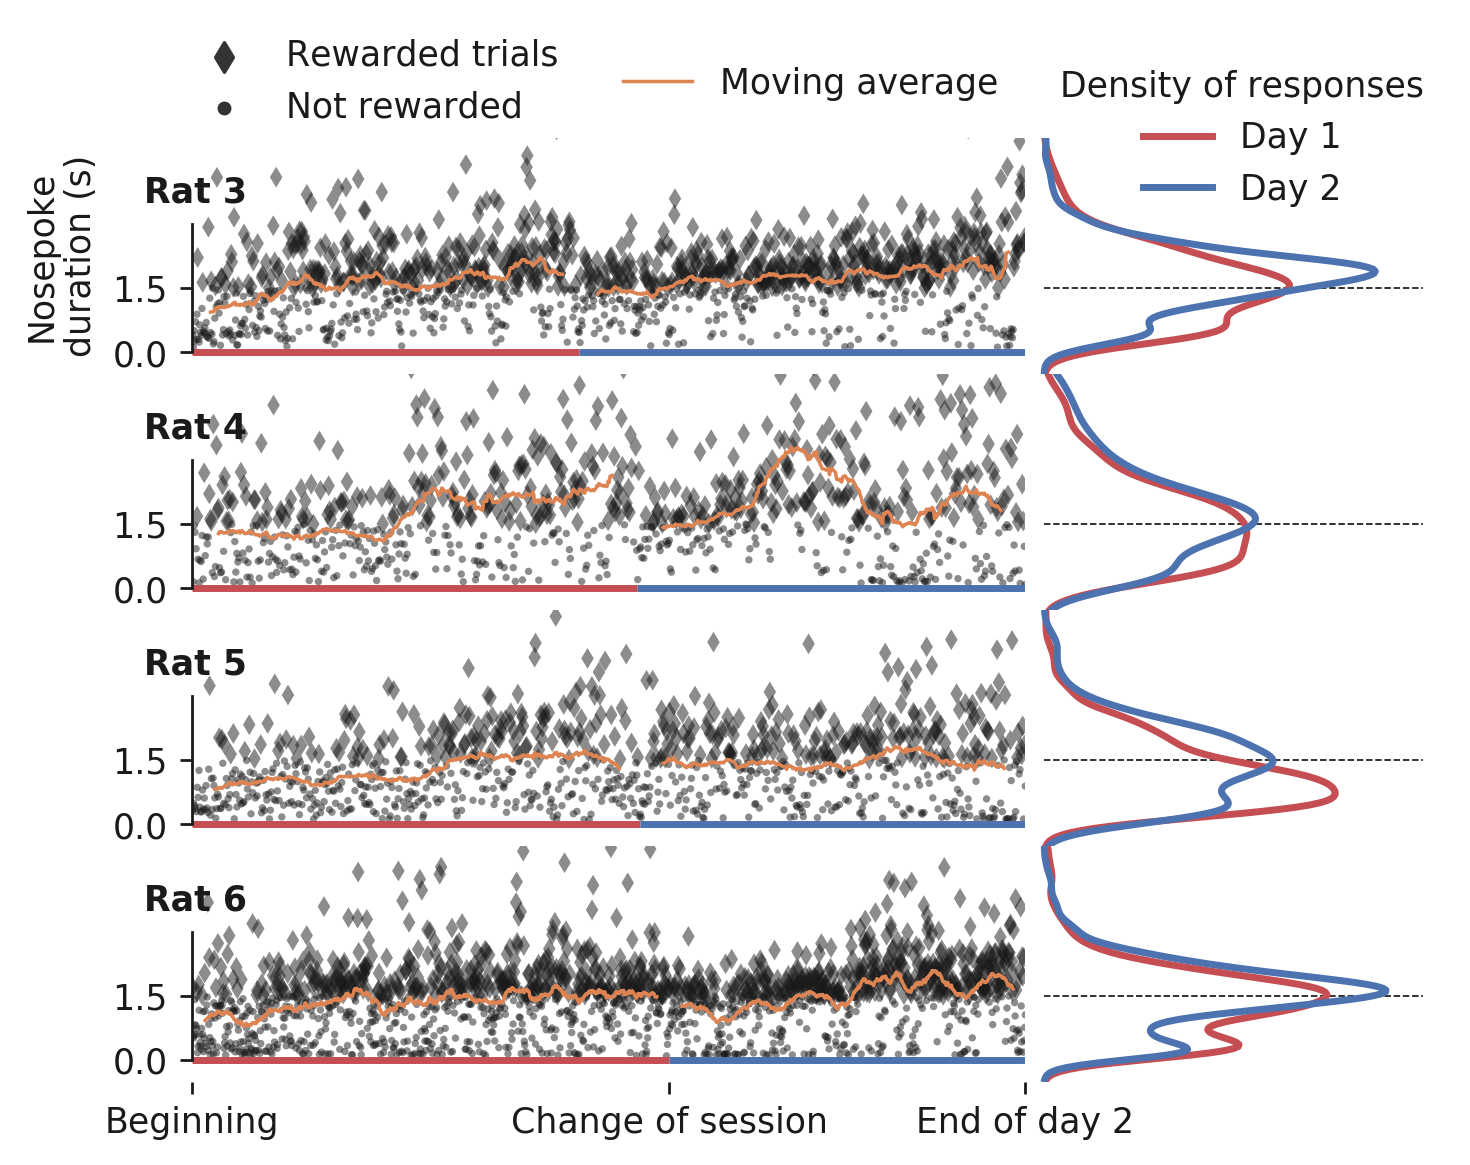

In [371]:
shape = (4,3)
ylim = (-.5, 5)
fig, ax = plt.subplots(*shape, figsize=(5,5), dpi=250)
fig.subplots_adjust(hspace=0, wspace=0, right=1, left=0)
i = 0
for i, label in enumerate(list(SHORTCUTS['groups']['eletro'].keys())[4:8]):
#     fig, ax = plt.subplots(figsize=(4,4))

    dur = select(io.load(label, 'behav_stats'), is_tired=False).reset_index()
    dur['first_half'] = True
    dur2 = select(io.load(label+'_2', 'behav_stats'), is_tired=False).reset_index()
    dur2['trial'] = dur2.trial + dur.trial.max()
    dur2['first_half'] = False
    dur = dur.append(dur2)
    dur['rewarded'] = dur.duration>1.5
    dur['rewarded'] = dur.rewarded.apply(lambda b: 'Rewarded trials' if b else 'Not rewarded')
#     dur['first_half'] = dur.trial < dur.trial.median()
    dur['percent_trial'] = dur.trial/dur.trial.max()*100
    
    axs = plt.subplot2grid(shape,(i,0), 1, 2)
    sns.scatterplot(y='duration', x='percent_trial', style='rewarded', data=dur, color='k', markers=['.','d'],
                    style_order=['Not rewarded', 'Rewarded trials'], ax=axs, size=3, linewidth=0, alpha=.5)
    dur[dur.first_half].set_index('percent_trial').duration.rolling(50, center=True)\
                                  .mean().plot(color=sns.color_palette('deep')[1], linewidth=1)
    dur[dur.first_half==False].set_index('percent_trial').duration.rolling(50, center=True)\
                              .mean().plot(color=sns.color_palette('deep')[1], linewidth=1, label='Moving average')

    x = axs.get_legend_handles_labels()
    axs.set_xlim(0,100)
    axs.set_ylim(ylim)
    axs.set_yticks([0, 1.5])
    axs.set_xticks([])
    
    good_labels = list(zip(*[(p, l) for p, l in zip(*x) if l in dur.rewarded.unique()][::-1]))
    
    
    final_first_sess = dur[dur.first_half].percent_trial.max()
    axs.hlines(0, 0, final_first_sess, colors=pal[0], linewidth=2)
    axs.hlines(0, final_first_sess, 100, colors=pal[1], linewidth=2)
    axs.set_xlabel('')
    
    
    axd = plt.subplot2grid(shape,(i,2))
    sns.distplot(dur.duration[dur.first_half], vertical=True, hist=False, color=pal[0],
                 kde_kws= dict(linewidth=2,clip=(0,5)), label = 'Day 1')
    sns.distplot(dur.duration[dur.first_half==False], vertical=True, hist=False, color=pal[1],
                 kde_kws= dict(linewidth=2, clip=(0,5)), label = 'Day 2')
    axd.hlines(1.5, 0., .7, linestyles='--', linewidth=.5)
    
    if i==1:
        good_labels = list(zip(*[(p, l) for p, l in zip(*x) if l in ['Moving average']]))
        axs.legend(*good_labels, title='', frameon=False, loc=(.5,2.1))
        axd.legend().remove()
        axs.set_ylabel('')
    elif i!= 0: 
        axs.legend().remove()
        axd.legend().remove()
        axs.set_ylabel('')
    else:
        good_labels = list(zip(*[(p, l) for p, l in zip(*x) if l in dur.rewarded.unique()][::-1]))
        axs.legend(*good_labels, title='', frameon=False, loc=(-.02,1))
        axd.legend(frameon=False, title='Density of responses', loc=(.05,.65))
        axs.set_ylabel('Nosepoke\nduration (s)')
        
    axs.text(-5.8, 3.5, 'Rat %d'%(i+3), weight = 'bold')

        
    axd.set_ylim(ylim)
    axd.set_axis_off()
    sns.despine(left=False, bottom=True)
    axs.spines['left'].set_bounds(0, 3)
axs.set_xticks([0, final_first_sess, 100])
axs.set_xticklabels(['Beginning', 'Change of session', 'End of day 2']);
# plt.tight_layout()


# Analysis of variance

In [534]:
from scipy.stats import f_oneway